In [1]:
import os
base_path = os.path.dirname(os.path.abspath(""))
base_path = base_path + "/headers/"
print(base_path)
header_path = base_path + 'header_data_treatment.ipynb'
app_name = 'merge_universities'
%run -i $header_path 

C:\Users\common\projet_3_lru\sorting_univ\script/headers/


# Loading data

In [2]:
#df_scanR = spark.read.format('json').load('file:\\' + scanR_path + 'publications.jsonl')

In [3]:
#df_scanR.write.mode('overwrite').parquet('file:\\' + scanR_path + 'publications.parquet')

In [4]:
#df_scanR = spark.read.format('parquet').load('file:\\' + scanR_path + '/publications.parquet')

In [5]:
#df_scanR.withColumn('domain', func.explode(func.col('domains'))).select('domain').limit(20).collect()

In [2]:
#df_inst_scanR = spark.read.option("multiline","true").json('file:\\' + scanR_path + 'organizations.json')
#df_inst_scanR.write.mode('overwrite').parquet('file:\\' + scanR_path + 'df_inst_scanR.parquet')
df_inst_scanR = spark.read.parquet('file:\\' + scanR_path + '/df_inst_scanR.parquet')

In [7]:
df_inst_scanR.printSchema()

root
 |-- acronym: struct (nullable = true)
 |    |-- default: string (nullable = true)
 |    |-- en: string (nullable = true)
 |    |-- fr: string (nullable = true)
 |-- activities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- label: struct (nullable = true)
 |    |    |    |-- default: string (nullable = true)
 |    |    |    |-- en: string (nullable = true)
 |    |    |    |-- fr: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- address: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- citycode: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- gps: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- localisationSu

In [8]:
#df_inst_scanR.count() #74252

74252

In [3]:
df_inst = (spark.read.format('parquet').load('file:\\' + main_path_openalex + 'institutions.parquet')
          .withColumn('id', func.regexp_replace(func.col('id'), 'https://openalex.org/', '')))


In [9]:
df_inst.printSchema()

root
 |-- associated_institutions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- country_id: string (nullable = true)
 |    |    |-- display_name: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- lineage: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- relationship: string (nullable = true)
 |    |    |-- ror: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- type_id: string (nullable = true)
 |-- cited_by_count: long (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_id: string (nullable = true)
 |-- counts_by_year: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cited_by_count: long (nullable = true)
 |    |    |-- oa_works_count: long (nullable = true)
 |    |    |-- works_count: long (nullable = true)
 |    |

# Normalisation functions for the match

In [4]:
from nltk.corpus import stopwords
print(stopwords.fileids())
stopwords_dict = {}
for language in stopwords.fileids():
    stopwords_dict[language.capitalize()] = stopwords.words(language)
    
def rm_stopwords(x,y):
    try:
        list_x = x.split(' ')
        list_y = y
        return(' '.join([word for word in list_x if word not in list_y]))
    except:
        return(x)
udf_rm_stopwords = func.udf(rm_stopwords)

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [5]:
stopwords_dict['French'] = stopwords_dict['French'] + ['l']

In [6]:
from nltk.stem.snowball import FrenchStemmer
from nltk.stem import PorterStemmer


In [7]:

def stemmer(x,y):
    try:
        if y == 'fr' or y == 'French' or y == 'Français':
            output = ' '.join([FrenchStemmer().stem(word) for word in x.split(' ')])
            return(output)
        else:
            output = ' '.join([PorterStemmer().stem(word) for word in x.split(' ')])
            return(output)
    except:
        return(x)
udf_stemmer = func.udf(stemmer)

In [8]:
import unidecode
def unidecode_debug(x):
    try:
        return unidecode.unidecode(x) if x is not None else None
       
    except:
        return(x)

udf_unidecode = func.udf(unidecode_debug, StringType())

# Selecting the institutions to match in OpenAlex with ScanR

In [9]:
french_inst_oa = (df_inst
                  .filter( (func.col('geo.country_code')=='FR')
                           | (func.col('geo.country')=="France"))
                  .withColumn('stopwords_fr',func.array([func.lit(x) for x in stopwords_dict['French']]))
                  .withColumn('stopwords_en',func.array([func.lit(x) for x in stopwords_dict['English']]))

                  .withColumn('name_fr', udf_rm_stopwords(func.lower(func.col('international.display_name.fr')), func.col('stopwords_fr')))
                  .withColumn('name_en', udf_rm_stopwords(func.lower(func.col('international.display_name.en')), func.col('stopwords_en')))
                  .withColumn('name_fr', udf_stemmer(func.lower(func.col('name_fr')), func.lit('fr')))
                  .withColumn('name_en', udf_stemmer(func.lower(func.col('name_en')), func.lit('en')))

                  .select(func.col('id').alias('inst_id'), func.col('geo.city').alias('city'), func.col('geo.latitude').alias('latitude'),
                         func.col('geo.longitude').alias('longitude'),
                         func.concat(func.array(func.col('display_name'), func.col('international.display_name.fr'), func.col('name_fr'), func.col('name_en')), 
                                     func.col('display_name_alternatives')).alias('names'), 
                        'works_count','associated_institutions','ids','display_name_acronyms',  'type', 'updated_date'
                 )
                 )


In [10]:
french_inst_oa.cache()
french_inst_oa.count()

9379

In [11]:
 french_inst_oa = (french_inst_oa.withColumn('max_updated_date', func.max(func.col('updated_date')).over(Window.partitionBy('inst_id')))
           .filter(func.col('updated_date')==func.col('max_updated_date'))
                  )

In [12]:
french_inst_oa.filter(func.col('inst_id') =="I4210137787").show()

+-----------+-----+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+--------+--------------------+--------------------+
|    inst_id| city|latitude|longitude|               names|works_count|associated_institutions|                 ids|display_name_acronyms|    type|        updated_date|    max_updated_date|
+-----------+-----+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+--------+--------------------+--------------------+
|I4210137787|Paris|48.85341|   2.3488|[Institut du Fer ...|       1176|   [{FR, https://ope...|{grid.462192.a, N...|                [IFM]|facility|2024-08-29T04:08:...|2024-08-29T04:08:...|
+-----------+-----+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+--------+--------------------+--------------------+



In [13]:
french_inst_oa.cache()
french_inst_oa.count()

4924

# Merge

In this part, we use observation-level characteristics to merge institutions between the two databases.
In each step : 
* we match by the characteristics related to the step
* we remove duplicates in this characteristic.

We perform this merge on measures by order of trustworthiness, including ror and wikidata identifiers, full name of the institution, acronym of the institution, and geolocalisation of the institution.

## Merge by ROR

In [19]:
merge_inst_by_ror = (french_inst_oa.withColumn('is_oa', func.lit(1))
                   .withColumn('ror_id', func.regexp_replace(func.col('ids.ror'), 'https://ror.org/',''))
                   .withColumn('wikidata_id', func.regexp_replace(func.col('ids.wikidata'), 'https://www.wikidata.org/wiki/',''))
                   .join(df_inst_scanR
                         .select(func.col('id').alias('scanr_id'),
                                 func.explode(func.col('externalIds')).alias('ext_id'))
                         .filter(func.col('ext_id.type')=='ROR')
                         .select('scanr_id', func.col('ext_id.id').alias('ror_id'), func.lit(1).alias('is_scanr')), on = 'ror_id', how = 'inner')
                  
                    )

merge_inst_by_ror.persist()
merge_inst_by_ror.filter(func.col('scanr_id').isNotNull()).count()


539

In [20]:
merge_inst_by_ror.filter(func.col('inst_id') =="I4210137787").show()

+------+-------+----+--------+---------+-----+-----------+-----------------------+---+---------------------+----+-----+-----------+--------+--------+
|ror_id|inst_id|city|latitude|longitude|names|works_count|associated_institutions|ids|display_name_acronyms|type|is_oa|wikidata_id|scanr_id|is_scanr|
+------+-------+----+--------+---------+-----+-----------+-----------------------+---+---------------------+----+-----+-----------+--------+--------+
+------+-------+----+--------+---------+-----+-----------+-----------------------+---+---------------------+----+-----+-----------+--------+--------+



In [21]:
all_matched_inst_oa = [row[0] for row in merge_inst_by_ror.select(func.col('inst_id')).distinct().collect()]
all_matched_inst_scanr = [row[0] for row in merge_inst_by_ror.select(func.col('scanr_id')).distinct().collect()]

In [22]:
print(len(all_matched_inst_oa), len(all_matched_inst_scanr))

269 269


## Merge by wikidata

In [23]:
merge_inst_by_wikidata = (french_inst_oa.withColumn('is_oa', func.lit(1))
                       #   .filter(~func.col('inst_id').isin(all_matched_inst_oa))
                   .withColumn('ror_id', func.regexp_replace(func.col('ids.ror'), 'https://ror.org/',''))
                   .withColumn('wikidata_id', func.regexp_replace(func.col('ids.wikidata'), 'https://www.wikidata.org/wiki/',''))
                   .join(df_inst_scanR
                       #  .filter(~func.col('id').isin(all_matched_inst_scanr))
                         .select(func.col('id').alias('scanr_id'),
                                 func.explode(func.col('externalIds')).alias('ext_id'))
                         .filter(func.col('ext_id.type')=='wikidata')
                         .select('scanr_id', func.col('ext_id.id').alias('wikidata_id'), func.lit(1).alias('is_scanr')), 
                         on = ['wikidata_id'], how = 'inner')
                  )
merge_inst_by_wikidata.persist()
merge_inst_by_wikidata.filter(func.col('scanr_id').isNotNull()).count()


641

In [24]:
#merge_inst_by_wikidata.filter(func.col('inst_id') =="I4210137787").show()

In [25]:
all_matched_inst_oa = list(set(all_matched_inst_oa + [row[0] for row in merge_inst_by_wikidata.select(func.col('inst_id')).distinct().collect()]))
all_matched_inst_scanr = list(set(all_matched_inst_scanr +  [row[0] for row in merge_inst_by_wikidata.select(func.col('scanr_id')).distinct().collect()]))
print(len(all_matched_inst_oa), len(all_matched_inst_scanr))

530 569


## Merge by name

In this part, we need to exclude some matches manually.

In [35]:
fr_oa_normalized_names = (french_inst_oa.withColumn('is_oa', func.lit(1))
                           #.filter(~func.col('inst_id').isin(all_matched_inst_oa))
                              .withColumn('stopwords_fr',func.array([func.lit(x) for x in stopwords_dict['French']]))
                              .withColumn('stopwords_en',func.array([func.lit(x) for x in stopwords_dict['English']]))

                        .withColumn('names', func.array_distinct(func.concat(
                            func.col('names'), func.transform(func.col('names'), lambda x:
                                                          func.regexp_replace(x, 'Centre Hospitalier Universitaire|CHU',
                                                                              'CHRU')))))
                        .withColumn('names', func.array_distinct(func.concat(
                            func.col('names'), func.transform(func.col('names'), lambda x:
                                                          func.regexp_replace(x, 'Centre Hospitalier Universitaire|CHU',
                                                                              'Centre Hospitalier Régional Universitaire')))))
                   .withColumn('name',func.explode(func.col('names')))
                    .filter(func.col('name').isNotNull())
                  .withColumn('name', func.regexp_replace(func.col('name'), r"\([A-z\s]*\)", ''))
                        .withColumn('name', func.regexp_replace(func.col('name'),  r"""[!\"#$%&'()*+,\-.\/:;<=>?@\[\\\]^_`{|}~]""", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'),  r"\s{2,}", ' ')) 
                  .withColumn('name', func.regexp_replace(func.col('name'), r"\s$", ''))
                        
                              .withColumn('name', udf_rm_stopwords(func.lower(func.col('name')),func.col('stopwords_fr')))
                              .withColumn('name', udf_rm_stopwords(func.lower(func.col('name')), func.col('stopwords_en')))
                   .filter(func.col('name').isNotNull())
                   .filter(func.col('name') != "")
                   .withColumn('name', udf_unidecode(func.col('name')))
                    .withColumn('name', func.lower(func.col('name')))
                 # .na.drop(subset = 'name')

                         .select('inst_id','name')
                         )
fr_oa_normalized_names.cache()
fr_oa_normalized_names.show()

+-----------+--------------------+
|    inst_id|                name|
+-----------+--------------------+
| I154526488|              inserm|
| I154526488|institut national...|
| I154526488|institut national...|
| I154526488|french nation ins...|
| I154526488|institut national...|
| I154526488|french institute ...|
| I204730241|universite paris ...|
| I204730241|    universite paris|
| I204730241|       univers paris|
| I204730241|        univers pari|
| I204730241|    university paris|
| I204730241|    universite paris|
| I102197404|universite paris sud|
| I102197404|universite paris sud|
| I102197404|   univers paris sud|
| I102197404|university paris sud|
| I102197404|universitat paris...|
| I102197404| university paris xi|
|I4210128565|          cea saclay|
|I4210128565|          cea saclay|
+-----------+--------------------+
only showing top 20 rows



In [36]:
fr_oa_normalized_names.filter(func.col('name')=="evosens").show()

+-----------+-------+
|    inst_id|   name|
+-----------+-------+
|I4210147280|evosens|
|I4210147280|evosens|
+-----------+-------+



In [37]:
scanr_normalized_names = (df_inst_scanR
                           #.filter(~func.col('id').isin(all_matched_inst_scanr))
                              .withColumn('stopwords_fr',func.array([func.lit(x) for x in stopwords_dict['French']]))
                              .withColumn('stopwords_en',func.array([func.lit(x) for x in stopwords_dict['English']]))
                              .withColumn('name_fr', udf_rm_stopwords(func.lower(func.col('label.fr')), func.col('stopwords_fr')))
                              .withColumn('name_en', udf_rm_stopwords(func.lower(func.col('label.en')), func.col('stopwords_en')))
                              .withColumn('name_fr', udf_stemmer(func.lower(func.col('name_fr')), func.lit('fr')))
                              .withColumn('name_en', udf_stemmer(func.lower(func.col('name_en')), func.lit('en')))

                         .select(func.col('id').alias('scanr_id'), 
                                                                       func.element_at(func.col('address.city'), 1).alias('city_scanr'),
                                 (func.array( func.lower((func.col('label.default'))), func.lower((func.col('label.fr'))),func.lower((func.col('label.en')))
                                     ,func.lower((func.col('name_fr'))), func.lower(func.col('name_en'))))
                                                                  .alias('label'), func.lit(1).alias('is_scanr'), 'stopwords_fr', 'stopwords_en')
                         .withColumn('name', func.explode(func.col('label')))
                          .filter(func.col('name').isNotNull())
                         .withColumn('name', func.regexp_replace(func.col('name'),   r"""[!\"#$%&'()*+,\-.\/:;<=>?@\[\\\]^_`{|}~]""", ' '))
                              .withColumn('name', udf_rm_stopwords(func.lower(func.col('name')), func.col('stopwords_fr')))
                              .withColumn('name', udf_rm_stopwords(func.lower(func.col('name')), func.col('stopwords_en')))

                         .withColumn('name', udf_unidecode(func.col('name')))
                       .withColumn('name', func.regexp_replace(func.col('name'),  r"\s{2,}", ' '))
                  .withColumn('name', func.regexp_replace(func.col('name'), r"\([A-z\s]*\)", ''))
                  .withColumn('name', func.regexp_replace(func.col('name'), r"\s$", ''))
                    .filter(func.col('name').isNotNull())
                    .filter(func.col('name') != "")

                          .select('scanr_id','name')

                         )
scanr_normalized_names.cache()
scanr_normalized_names.show()

+---------+--------------------+
| scanr_id|                name|
+---------+--------------------+
|200012318|etablissement ele...|
|200012318|etablissement ele...|
|200012318|etabl elevag 04 0...|
|200034528|centre hospitalie...|
|200034528|centre hospitalie...|
|200034528|centr hospitali u...|
|200035335|pole metropolitai...|
|200035335|pole metropolitai...|
|200035335|pol metropolitain...|
|200046977|      metropole lyon|
|200046977|      metropole lyon|
|200046977|       metropol lyon|
|226400018|departement pyren...|
|226400018|departement pyren...|
|226400018| depart pyren atlant|
|233500016|     region bretagne|
|233500016|     region bretagne|
|233500016|      region bretagn|
|239710015|conseil regional ...|
|239710015|conseil regional ...|
+---------+--------------------+
only showing top 20 rows



In [73]:
df_inst_scanR.filter(func.col('id')=="200711884S").show(truncate = False)

+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [75]:
scanr_normalized_names.filter( func.col('name').contains("laboratoire chimie physique matiere")
                             ).show(100,truncate = False)

+----------+-----------------------------------------------+
|scanr_id  |name                                           |
+----------+-----------------------------------------------+
|199712659C|laboratoire chimie physique matiere rayonnement|
|199712659C|laboratoire chimie physique matiere rayonnement|
|199712659C|laboratoire chimie physique matiere rayonnement|
+----------+-----------------------------------------------+



In [39]:
excluded_matches = [['I4210115519','199213454N'],
                    ["I4210090995","200819989X"], 
                    ['I4210091225', '200918488L'], 
                    ['I4210115034',"26420030400030"],
                   ['I4210126712', '26510005700180'],
                    ['I4210150621', '439946427'],
                    ['I4210112706','783706971'],
                    ['I4210150621','783706971'],
                    ['I3131982239','439946427'],
                    ['I4210108239','201220167Y'],
                    ['I4210166444','grid.452487.8'],
                    ['I4210166444','18000602500076'],
                    ['I4210166444','0755362W'],
                    ['I4210166444','grid.463365.1'],
                    ['I4210151275','201722624X'],
                    ['I4210144972','199513603M'],
                    ['I4210098902','199413775D'],
                    ['I4210155549','199916828A'],
                    ['I4210155549','200016747H'],
                    ['I4210115290','18007301700543'],
                    ['I4210086462','196617874F'],
                    ['I131077856','33159627000040'],
                    ['I4210160215','199719343T'],
                    ['I2799535048','77566591200033'],
                    ['I205358943','77568822900050'],
                    ['I4210135895','201624288K'],
                    ['I4210119188','453278038'],
                    ['I4210133069','782879951'],
                    ['I4210136727','26440013600026'],
                    ['I265217849','77572915500041'],
                    ['I4210113835','418559878'],
                    ['I85905123','775671456'],
                    ['I4210121454','312381015'],
                    ['I4210132720','199814162G'],
                    ['I4210104640','201420758G'],
                    ['I4210120493','199511791T'],
                    ['I2799857465','199613807E'],
                    ['I4210109170','199912473S'],
                    ['I4210109170','199812952S'],
                    ['I4210110752','200212212V'],
                    ['I4210096419','200016656J'],
                    ['I4210096419','grid.438326.8'],
                    ['I4210122952','200016656J'],
                    ['I4210096419','200016656J'],
                    ['I4210096419','200610832C'],
                    ['I4210122952','200610832C'],
                    ['I4210122952','201722455N'],
                    ['I4210096419','201722455N'],
                    ['I4210113730','grid.30390.39'],
                    ['I4210137648','199915931A'],
                    ['I4210092271','130005481'],
                    ['I4210088019','195517880K']
                   ]

merge_inst_by_names = (fr_oa_normalized_names
                       .filter(func.col('name')!='')

                   .join(scanr_normalized_names.filter(func.col('name')!='')
                         
                              #    .filter(~func.col('scanr_id').isin(list_mapped))
                         ,on = ['name'], how = 'inner')
                   .distinct()
                   .filter( func.expr('not ( (' + ' ) or ( '.join(
                [' ( inst_id == "' + element[0] + '" ) and ( scanr_id == "' + element[1] + '" )' for element in excluded_matches]) +' ) )'))
                    .distinct()
                    .withColumn('several_id', 
                         ((func.size(func.collect_set('inst_id').over(Window.partitionBy('name')))>1) |
                         (func.size(func.collect_set('scanr_id').over(Window.partitionBy('name')))>1)).cast('int'))

                  )


In [40]:
merge_inst_by_names.persist()
merge_inst_by_names.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id').distinct().count()


3974

In [41]:
merge_inst_by_names.filter(func.col('name')=='evosens').show(truncate = False)

+-------+-----------+---------+----------+
|name   |inst_id    |scanr_id |several_id|
+-------+-----------+---------+----------+
|evosens|I4210147280|511170946|0         |
+-------+-----------+---------+----------+



In [42]:
merge_inst_by_names.filter(func.col('scanr_id').isNotNull()).filter('several_id>0').sort('name').show(truncate = False)

+-----------------------------------+-----------+--------+--------+---------+----------------------------------------------------------------------------------------------------------------------------------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
all_matched_inst_oa = list(set(all_matched_inst_oa + [row[0] for row in merge_inst_by_names.select(func.col('inst_id')).distinct().collect()]))
all_matched_inst_scanr = list(set(all_matched_inst_scanr +  [row[0] for row in merge_inst_by_names.select(func.col('scanr_id')).distinct().collect()]))
print(len(all_matched_inst_oa), len(all_matched_inst_scanr))

3119 4051


## Merge by acronym

In [43]:
normalized_oa_acronyms = (french_inst_oa.withColumn('is_oa', func.lit(1))
                          # .filter(~func.col('inst_id').isin(all_matched_inst_oa))
                        .withColumn('display_name_acronyms', func.array_distinct(func.concat(
                            func.col('display_name_acronyms'), 
                            func.array_compact(func.array_distinct(
                            func.flatten(func.transform(func.col('names'), lambda x:
                            func.when(x.rlike('Centre Hospitalier Universitaire|CHU|Centre Hospitalier Régional Universitaire|CHRU'),
                                                                              func.array([func.lit(a) for a in ['CHRU','CHU']]))
                                                       .otherwise(func.array(x))
                                                       )))))))
                          .withColumn('name', func.explode_outer(func.col('names')))
                          .withColumn('display_name_acronyms', func.when(
                              func.col('display_name_acronyms').isNull(),
                              func.when( (func.size(func.split(func.col('name'), ' '))==1), func.array(func.col('name')))).otherwise(func.col('display_name_acronyms')))
                          .drop('name').distinct()
                   .withColumn('name',func.explode(func.col('display_name_acronyms')))
                 # .withColumn('name', func.when(func.col('name').isin('CHRU','CHU'), func.concat_ws(' ', func.col('name'), func.col('city'))).otherwise(func.col('name')))
                   .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                   .withColumn('name', udf_unidecode(func.col('name')))
                          .select('name','inst_id','city')
                         )
normalized_oa_acronyms.cache()
normalized_oa_acronyms.show()

+--------------------+-----------+--------------------+
|                name|    inst_id|                city|
+--------------------+-----------+--------------------+
|                CHRU|I4210105796|               Reims|
|                 CHU|I4210105796|               Reims|
|centr hospitali u...|I4210105796|               Reims|
|University Hospit...|I4210105796|               Reims|
|               LPCNO|I4210156113|            Toulouse|
|Laboratoire de Ph...|I4210156113|            Toulouse|
|laboratoir de phy...|I4210156113|            Toulouse|
|Laboratoire de Bi...|I4210091644|Illkirch-Graffens...|
|laboratoir de bio...|I4210091644|Illkirch-Graffens...|
|Laboratoire de Bi...|I4210091644|Illkirch-Graffens...|
|Laboratory of Bio...|I4210091644|Illkirch-Graffens...|
|                 UGA| I899635006|Saint-Martin-d'Hères|
|Grenoble Alpes Un...| I899635006|Saint-Martin-d'Hères|
|universite Grenob...| I899635006|Saint-Martin-d'Hères|
|univers grenoble alp| I899635006|Saint-Martin-d

In [44]:
normalized_oa_acronyms.filter(func.col('inst_id')=="I4210143253").show()

+--------------------+-----------+--------------+
|                name|    inst_id|          city|
+--------------------+-----------+--------------+
|Cognitive Neuroim...|I4210143253|Gif-sur-Yvette|
|cognit neuroimag lab|I4210143253|Gif-sur-Yvette|
|              UNICOG|I4210143253|Gif-sur-Yvette|
|Cognitive Neuroim...|I4210143253|Gif-sur-Yvette|
|cognit neuroimag lab|I4210143253|Gif-sur-Yvette|
|              UNICOG|I4210143253|Gif-sur-Yvette|
+--------------------+-----------+--------------+



In [45]:
normalized_scanr_acronyms = (df_inst_scanR
                         #  .filter(~func.col('id').isin(all_matched_inst_scanr))

                         .withColumn('acronym.default', 
                                    func.when( (func.col('acronym.default').isNull()) & 
                                              (func.col('label.default').rlike('Centre Hospitalier Universitaire|CHU')), "CHU")
                                        .when( (func.col('acronym.default').isNull()) & 
                                              (func.col('label.default').rlike('Centre Hospitalier Régional Universitaire|CHRU')), "CHRU")
                                        .otherwise(func.col('acronym.default'))
                                    )
                         .select(func.col('id').alias('scanr_id'), func.element_at(func.col('address.city'), 1).alias('city'),
                                 (func.array(func.col('acronym.default'),func.col('acronym.fr'), func.col('acronym.en')))
                                                                  .alias('name'), func.lit(1).alias('is_scanr'), 'label')
                        .withColumn('name', func.array_distinct(func.concat(
                            func.col('name'), func.array_compact(func.array_distinct(
                                func.flatten(func.transform(
                            func.array(func.col('label.default'), func.col('label.fr')), lambda x:
                                        func.when(x.rlike('Centre Hospitalier Universitaire|CHU|Centre Hospitalier Régional Universitaire|CHRU'),
                                                                              func.array([func.lit(a) for a in ['CHRU','CHU']]))
                                .otherwise(func.array(func.lit(None)) ) )))))))
                         .withColumn('name', func.explode(func.col('name')))
                        .filter(func.col('name').isNotNull())
                         .withColumn('name',func.when(func.col('name').isNotNull(), udf_unidecode(func.col('name'))))
                         .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                         #.withColumn('name', func.when(func.col('name').isin('CHRU','CHU'), func.concat_ws(' ', func.col('name'), func.col('city'))).otherwise(func.col('name')))
                         .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                            )
normalized_scanr_acronyms.cache()
normalized_scanr_acronyms.show()

+---------+--------------------+--------------------+--------+--------------------+
| scanr_id|                city|                name|is_scanr|               label|
+---------+--------------------+--------------------+--------+--------------------+
|200012318|     Digne-les-Bains|                OIER|       1|{ETABLISSEMENT DE...|
|200034528|      Fort-de-France|      CHU Martinique|       1|{Centre Hospitali...|
|200034528|      Fort-de-France|                CHRU|       1|{Centre Hospitali...|
|200034528|      Fort-de-France|                 CHU|       1|{Centre Hospitali...|
|244200630|Saint-Symphorien-...|              CoPLER|       1|{Communauté de co...|
|247800584|          Versailles|               CAVGP|       1|{Communauté d’agg...|
|249720061|      Fort-de-France|               CACEM|       1|{Communauté d'agg...|
|253401442|         Montpellier|    EID Mediterranee|       1|{Entente Interdép...|
|256701152|        Schiltigheim|                SDEA|       1|{Syndicat des 

In [46]:
normalized_scanr_acronyms.filter(func.col('name') =="UNICOG").show()

+----------+--------------+------+--------+--------------------+
|  scanr_id|          city|  name|is_scanr|               label|
+----------+--------------+------+--------+--------------------+
|200616272R|Gif-sur-Yvette|UNICOG|       1|{Neuroimagerie co...|
|202023519G|Gif-sur-Yvette|UNICOG|       1|{Neuroimagerie du...|
+----------+--------------+------+--------+--------------------+



In [47]:
merge_inst_by_acronyms = (normalized_oa_acronyms
                   .join(normalized_scanr_acronyms
                         ,
                         on = ['name','city'], how = 'inner')
                                     .withColumn('several_id', 
                                          ((func.size(func.collect_set('inst_id').over(Window.partitionBy('name')))>1) |
                                        (  (func.size(func.collect_set('scanr_id').over(Window.partitionBy('name')))>1) & 
                                          (func.size(func.collect_set(func.lower(func.col('label.default'))).over(Window.partitionBy('name')))>1))
                                          ).cast('int'))

                  )


In [48]:
merge_inst_by_acronyms.persist()
merge_inst_by_acronyms.filter(func.col('scanr_id').isNotNull()).select('inst_id','scanr_id','several_id').distinct().groupBy('several_id').count().show()


+----------+-----+
|several_id|count|
+----------+-----+
|         1|  529|
|         0| 1667|
+----------+-----+



In [49]:
merge_inst_by_acronyms.filter(func.col('scanr_id')=="330715368").show()

+----+----+-------+--------+--------+-----+----------+
|name|city|inst_id|scanr_id|is_scanr|label|several_id|
+----+----+-------+--------+--------+-----+----------+
+----+----+-------+--------+--------+-----+----------+



In [50]:
merge_inst_by_acronyms.filter( (func.col('scanr_id').isNotNull()) & (func.col('several_id')==1)).show(truncate = False)

+-----+----------------+-----------+-------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|name |city            |inst_id    |scanr_id     |is_scanr|label                                                                                                                                                         |several_id|
+-----+----------------+-----------+-------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|ADEN |Rouen           |I4387154241|200014532A   |1       |{Appareil digestif environnement nutrition, NULL, Appareil digestif environnement nutrition}                                                                  |1         |
|ADEN |Rouen           |I4387154241|201220158N   |1       |{Nutrition, Inflammat

In [51]:
all_matched_inst_oa = list(set(all_matched_inst_oa + [row[0] for row in merge_inst_by_acronyms.filter('several_id=0').select(func.col('inst_id')).distinct().collect()]))
all_matched_inst_scanr = list(set(all_matched_inst_scanr +  [row[0] for row in merge_inst_by_acronyms.select(func.col('scanr_id')).filter('several_id=0').distinct().collect()]))
print(len(all_matched_inst_oa), len(all_matched_inst_scanr))

3405 4378


## Merge by geolocalisation

In [52]:
merge_inst_by_geo = (french_inst_oa.withColumn('is_oa', func.lit(1))
                           #.filter(~func.col('id').isin(all_matched_inst_scanr))

                       .withColumn('latitude', func.round(func.col('latitude'),3))
                       .withColumn('longitude', func.round(func.col('longitude'),3))
                       .withColumn('names', func.array_compact(func.col('names')))
                   .join(df_inst_scanR
                         #  .filter(~func.col('id').isin(all_matched_inst_scanr))

                         .select(func.col('id').alias('scanr_id'), func.round(func.element_at(func.col('address.gps.lat'), 1),3).alias('latitude'),
                                 func.round(func.element_at(func.col('address.gps.lon'), 1),3).alias('longitude')
                                 , func.lit(1).alias('is_scanr'),
                                 func.array_compact(
                                     func.array(func.col('label.default'),func.col('label.fr'),func.col('label.en'),
                                func.col('acronym.default'),func.col('acronym.fr'),func.col('acronym.en')) ).alias('label')
                                )
                         
                         ,
                         on = ['longitude','latitude'], how = 'inner')
                  .withColumn('indistinct', ((func.size(func.collect_set('inst_id').over(Window.partitionBy('longitude','latitude')))>1) |
                                          (func.size(func.collect_set('scanr_id').over(Window.partitionBy('longitude','latitude')))>1)).cast('int'))
                 .filter( (func.col('indistinct')==0) | (func.arrays_overlap(
                     func.transform(func.col('names'), lambda x: (func.lower(x))),
                     func.transform(func.col('label'), lambda x: (func.lower(x)))) )
                        )
                  .withColumn('several_id', ((func.size(func.collect_set('inst_id').over(Window.partitionBy('longitude','latitude')))>1) |
                                          (func.size(func.collect_set('scanr_id').over(Window.partitionBy('longitude','latitude')))>1)).cast('int'))

                 )


In [53]:
merge_inst_by_geo.persist()
merge_inst_by_geo.count()


1016

In [54]:
merge_inst_by_geo.filter(func.col('indistinct')==0).show(truncate = False)

+---------+--------+-----------+-----------+-------------------------------------------------------------------------------------------------------------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Final matching table

In [55]:
oa_scanr_id = (merge_inst_by_ror.filter(func.col('scanr_id').isNotNull()).select('scanr_id', 'inst_id')
                    .unionAll(merge_inst_by_wikidata.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .unionAll(merge_inst_by_names.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .unionAll(merge_inst_by_acronyms.filter(( func.col('scanr_id').isNotNull()) & (func.col('several_id')==0)).select('scanr_id','inst_id'))
                    .unionAll(merge_inst_by_geo.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .distinct()
                   )

In [56]:
oa_scanr_id.show()

+----------+-----------+
|  scanr_id|    inst_id|
+----------+-----------+
| 180070039|I4210088668|
|199812861T|I4210139497|
| 110043015|I4210141076|
|196717612S|I4210118525|
| 753408962|I3018083178|
|200417733M|I4210136726|
|199512096Z|I4210152651|
| 484781133|I4210121021|
| 130026024| I277688954|
|199712659C|I4210141568|
|199511947M|I4210087602|
|201320733J|I4210094488|
|199712084C|I4210097863|
| 775671456|  I85905123|
| 514005123|  I51205905|
| 193509361|  I56067802|
| 317540581| I152238723|
|199317388K|I4210128885|
|201220169A|I4210112918|
|200918542V|I4210134622|
+----------+-----------+
only showing top 20 rows



## Save

In [57]:
oa_scanr_id.write.mode('overwrite').parquet('file:\\' + scanR_path + '/oa_scanr_id.parquet')

# Assessment

In [14]:
oa_scanr_id = spark.read.format('parquet').load('file:\\' + scanR_path + '/oa_scanr_id.parquet')

In [15]:
oa_scanr_id.select('scanr_id').distinct().count() #3687

4632

In [16]:
test = df_inst_scanR.join(oa_scanr_id.withColumnRenamed('scanr_id','id'), on = 'id', how = 'left')
test.cache()

DataFrame[id: string, acronym: struct<default:string,en:string,fr:string>, activities: array<struct<code:string,label:struct<default:string,en:string,fr:string>,type:string>>, address: array<struct<address:string,city:string,citycode:string,country:string,gps:struct<lat:double,lon:double>,localisationSuggestions:array<string>,main:boolean,postcode:string,provider:string,score:double,urbanUnitCode:string,urbanUnitLabel:string>>, alias: array<string>, badges: array<struct<code:string,label:struct<en:string,fr:string>>>, createdAt: string, creationYear: bigint, description: struct<default:string,en:string,fr:string>, email: string, employeesInfo: struct<date:bigint,employeesNb:bigint>, endDate: string, evaluations: array<struct<evaluator:string,url:string,year:bigint>>, externalIds: array<struct<id:string,type:string>>, focus: array<string>, institutions: array<struct<fromDate:string,label:string,relationType:string,structure:string>>, isFrench: boolean, keywords: struct<default:array<str

In [17]:
test.select(func.col('id').alias('scanr_id'),
                               func.col('address.city')).show()

+---------+--------------------+
| scanr_id|                city|
+---------+--------------------+
|200012318|   [Digne-les-Bains]|
|200034528|    [Fort-de-France]|
|200035335|            [Nantes]|
|200046977|              [Lyon]|
|226400018|               [Pau]|
|233500016|            [Rennes]|
|239710015|       [Basse-Terre]|
|244200630|[Saint-Symphorien...|
|246700488|        [Strasbourg]|
|247800584|        [Versailles]|
|249720061|    [Fort-de-France]|
|253401442|       [Montpellier]|
|256701152|      [Schiltigheim]|
|256701160|        [Strasbourg]|
|256900994|              [Lyon]|
|258500222|  [La Roche-sur-Yon]|
|258600972|[Chasseneuil-du-P...|
|260600150|           [Antibes]|
|260804901|[Charleville-Mézi...|
|263800211|      [Saint-Égrève]|
+---------+--------------------+
only showing top 20 rows



In [18]:
oa_for_fuzzy = (french_inst_oa
                             .withColumn('names', func.explode(func.col('names')))
                             .filter(func.col('names').isNotNull())
                             .select('inst_id', 'names', 'city'))
func.broadcast(oa_for_fuzzy)

DataFrame[inst_id: string, names: string, city: string]

In [19]:
test_fuzzy_matching = (test
                       .filter(func.col('inst_id').isNull())
                       .select(func.col('id').alias('scanr_id'),
                               func.explode(func.col('address.city')).alias('city'), func.col('label.default'))
                       .join(oa_for_fuzzy,
                             on = ['city'], how ='inner')
                       
                      # .withColumn('name', func.explode(func.col('names')))
                      )
test_fuzzy_matching.cache()
test_fuzzy_matching.show()

+------+---------+--------------------+-----------+--------------------+
|  city| scanr_id|             default|    inst_id|               names|
+------+---------+--------------------+-----------+--------------------+
|Nantes|200035335|Pôle métropolitai...|I4399598365|centr de recherch...|
|Nantes|200035335|Pôle métropolitai...|I4399598365|Centre de recherc...|
|Nantes|200035335|Pôle métropolitai...|I4396570565|groupement ligéri...|
|Nantes|200035335|Pôle métropolitai...|I4396570565|Groupement Ligéri...|
|Nantes|200035335|Pôle métropolitai...|I4392021239|  Laboratoire SPHERE|
|Nantes|200035335|Pôle métropolitai...|I4392021239|methodS in Patien...|
|Nantes|200035335|Pôle métropolitai...|I4392021239|method patient-ce...|
|Nantes|200035335|Pôle métropolitai...|I4392021239|methodS in Patien...|
|Nantes|200035335|Pôle métropolitai...|I4392021198|Centre de Recherc...|
|Nantes|200035335|Pôle métropolitai...|I4392021198|   Laboratoire CR2TI|
|Nantes|200035335|Pôle métropolitai...|I4392021198|

In [21]:
from rapidfuzz import fuzz
from pyspark.sql.types import *
udf_ratio = func.udf(fuzz.ratio, DoubleType() )
udf_token_sort = func.udf(fuzz.token_sort_ratio, DoubleType())

In [39]:
test_fuzzy_matching_1 = (test_fuzzy_matching
                         .withColumn('levenshtein', func.levenshtein(func.col('default'), func.col('names'))/func.length(func.col('default')))
                         .withColumn('fuzz_ratio', udf_ratio(func.col('default'), func.col('names')))
                         .withColumn('token_sort_ratio', udf_token_sort(func.col('default'), func.col('names')))
                         .withColumn('n_shared_tokens', func.size(func.array_intersect(func.split(func.col('names'),' '), func.split( func.col('default'), ' '))))
                         .filter( ((func.col('levenshtein')<=0.5) | (func.col('token_sort_ratio') >= 50) | (func.col('fuzz_ratio') >= 50))
                                 & (func.col('n_shared_tokens') >=2))
                         .withColumn('min_match_measure_l', func.min(func.col('levenshtein')).over(Window.partitionBy('scanr_id')))
                         .withColumn('max_match_measure_r', func.max(func.col('fuzz_ratio')).over(Window.partitionBy('scanr_id')))
                         .withColumn('max_match_measure_t', func.max(func.col('token_sort_ratio')).over(Window.partitionBy('scanr_id')))
                         .withColumn('max_match_measure_n', func.max(func.col('n_shared_tokens')).over(Window.partitionBy('scanr_id')))

                        )

test_fuzzy_matching_1.cache()

test_fuzzy_matching_1.show(truncate = False)

+---------+----------+------------------------------------------------------------------------------------------+-----------+---------------------------------------------------------------------------+-------------------+------------------+------------------+---------------+-------------------+-------------------+-------------------+-------------------+
|city     |scanr_id  |default                                                                                   |inst_id    |names                                                                      |levenshtein        |fuzz_ratio        |token_sort_ratio  |n_shared_tokens|min_match_measure_l|max_match_measure_r|max_match_measure_t|max_match_measure_n|
+---------+----------+------------------------------------------------------------------------------------------+-----------+---------------------------------------------------------------------------+-------------------+------------------+------------------+---------------+-------------

In [51]:
test_fuzzy_matching_1.count()

50051

In [50]:
test_fuzzy_matching_1.filter( (func.col('levenshtein')== func.col('min_match_measure_l'))
                             | (func.col('fuzz_ratio')==       func.col('max_match_measure_r'))
                             | (func.col('token_sort_ratio')== func.col('max_match_measure_t'))
                             | (func.col('n_shared_tokens')==  func.col('max_match_measure_n'))
                            ).count()

14919

In [108]:
list_tokens_to_rm = ['école nationale supérieure ', 'ecole nationale supérieur ', 'institut national supérieur ', 'école de ', 'école du ', 'ecole ','université de ', 'université ', 'universite',
                     'laboratoire de ','laboratoire du ','laboratoire ', 'groupe à 5 ans ', 'ufr ', 'supérieur ', 'supérieure ', 'national ', 'nationale ',
                    "groupe d'études ", "groupe des écoles ",  "centre de recherches " "centre de ", "centre du ","centre ", "fondation ", "institut de recherche", "institut de ", "institut du ", "institut ",
                    "site de ", 'association de ', 'association ',  'campus de ', 'campus du ', 'campus ', 'observatoire des ', 'observatoire du ', 'observatoire ',
                    ]


In [109]:
all_stopwords_expr = ' ' + ' | '.join(stopwords_dict['English'] + stopwords_dict['French'] + ['-', 'du', 'de', 'des', 'la', 'le', 'les' , 'en', 'dans', 'et', ]) + ' ' + "|d'|" + "l'"
all_stopwords_expr

" i | me | my | myself | we | our | ours | ourselves | you | you're | you've | you'll | you'd | your | yours | yourself | yourselves | he | him | his | himself | she | she's | her | hers | herself | it | it's | its | itself | they | them | their | theirs | themselves | what | which | who | whom | this | that | that'll | these | those | am | is | are | was | were | be | been | being | have | has | had | having | do | does | did | doing | a | an | the | and | but | if | or | because | as | until | while | of | at | by | for | with | about | against | between | into | through | during | before | after | above | below | to | from | up | down | in | out | on | off | over | under | again | further | then | once | here | there | when | where | why | how | all | any | both | each | few | more | most | other | some | such | no | nor | not | only | own | same | so | than | too | very | s | t | can | will | just | don | don't | should | should've | now | d | ll | m | o | re | ve | y | ain | aren 

In [110]:


test_fuzzy_matching_2 = (test_fuzzy_matching_1
                        # .filter( (func.col('levenshtein')== func.col('min_match_measure_l'))
                        #     | (func.col('fuzz_ratio')==       func.col('max_match_measure_r'))
                        #     | (func.col('token_sort_ratio')== func.col('max_match_measure_t'))
                        #     | (func.col('n_shared_tokens')==  func.col('max_match_measure_n'))
                        #    )
                         .withColumn('default', func.regexp_replace(func.col('default'), func.col('city'), ''))
                         .withColumn('names', func.regexp_replace(func.col('names'), func.col('city'), ''))

                         .withColumn('default', func.regexp_replace(func.lower(func.col('default')), '|'.join(list_tokens_to_rm + [stemmer(token, 'fr') for token in list_tokens_to_rm]), '' ))
                         .withColumn('names', func.regexp_replace(func.lower(func.col('names')), '|'.join(list_tokens_to_rm + [stemmer(token, 'fr') for token in list_tokens_to_rm]), '' ))
                         .withColumn('default', func.regexp_replace(func.col('default'), all_stopwords_expr, ' '))
                         .withColumn('names', func.regexp_replace(func.col('names'), all_stopwords_expr , ' '))

                         .withColumn('default', func.regexp_replace(func.col('default'), r'[[^A-Za-z0-9éèê -]]+', ''))  # Remove special characters
                         .withColumn('names', func.regexp_replace(func.col('names'), r'[[^A-Za-z0-9éèê -]]+', ''))  # Remove special characters
                                                                           
                         .withColumn('levenshtein', func.levenshtein(func.col('default'), func.col('names'))/func.length(func.col('default')))
                         .withColumn('fuzz_ratio', udf_ratio(func.col('default'), func.col('names')))
                         .withColumn('token_sort_ratio', udf_token_sort(func.col('default'), func.col('names')))
                         .withColumn('n_shared_tokens', func.size(func.array_intersect(func.split(func.col('names'),' '), func.split( func.col('default'), ' '))))
                         .filter( ((func.col('levenshtein')<=0.5) | (func.col('token_sort_ratio') >= 50) | (func.col('fuzz_ratio') >= 50))
                                 & (func.col('n_shared_tokens') >0))


                         .withColumn('min_match_measure_l', func.min(func.col('levenshtein')).over(Window.partitionBy('scanr_id')))
                         .withColumn('max_match_measure_r', func.max(func.col('fuzz_ratio')).over(Window.partitionBy('scanr_id')))
                         .withColumn('max_match_measure_t', func.max(func.col('token_sort_ratio')).over(Window.partitionBy('scanr_id')))
                         .withColumn('max_match_measure_n', func.max(func.col('n_shared_tokens')).over(Window.partitionBy('scanr_id')))

                        )
test_fuzzy_matching_2.cache()
test_fuzzy_matching_2.show(truncate = False)

+---------+----------+---------------------------------------------------------------------------------------------------+-----------+---------------------------------------------------------------------------------+-------------------+------------------+------------------+---------------+-------------------+-------------------+-------------------+-------------------+
|city     |scanr_id  |default                                                                                            |inst_id    |names                                                                            |levenshtein        |fuzz_ratio        |token_sort_ratio  |n_shared_tokens|min_match_measure_l|max_match_measure_r|max_match_measure_t|max_match_measure_n|
+---------+----------+---------------------------------------------------------------------------------------------------+-----------+---------------------------------------------------------------------------------+-------------------+------------------+---

In [111]:
test_fuzzy_matching_2.count()

17883

In [79]:
test.show()

+---------+--------------------+----------+--------------------+--------------------+------+----------+------------+-----------+-----+-------------+----------+-----------+--------------------+-----+------------+--------+------------------+----------------+--------------------+-------+-------------+--------------------+--------------------+------+-------+-----+------------+---------+----------+--------------------+--------+----------+------+-----------+
|       id|             acronym|activities|             address|               alias|badges| createdAt|creationYear|description|email|employeesInfo|   endDate|evaluations|         externalIds|focus|institutions|isFrench|          keywords|            kind|               label|leaders|legalCategory|               level|               links|nature|parents|phone|predecessors|relations| removedAt|        socialMedias|spinoffs| startDate|status|    inst_id|
+---------+--------------------+----------+--------------------+--------------------+-

In [81]:
test.filter(func.col('inst_id').isNull()).select('label.default').show(50, truncate = False)

+----------------------------------------------------------------------------+
|default                                                                     |
+----------------------------------------------------------------------------+
|ETABLISSEMENT DE L'ELEVAGE 04 06 83                                         |
|Centre Hospitalier Universitaire de Martinique                              |
|Pôle métropolitain Nantes Saint-Nazaire                                     |
|Métropole de Lyon                                                           |
|Département des Pyrénées Atlantiques                                        |
|Région Bretagne                                                             |
|Conseil Régional de Guadeloupe                                              |
|Communauté de communes du Pays entre Loire et Rhône                         |
|Communauté d’agglomération Versailles Grand Parc                            |
|Communauté d'agglomération du Centre de la Martiniq

In [82]:
test.filter(func.col('inst_id').isNull()).groupBy('kind').count().show()

+--------------------+-----+
|                kind|count|
+--------------------+-----+
|[Secteur privé, O...|    2|
|    [Secteur public]|13604|
|[Structure de rec...|    1|
|                  []| 6330|
|[Structure de rec...|    2|
|     [Secteur privé]|40183|
|[Organisation int...|    1|
|[Organisation int...|    8|
|[Structure de rec...| 9470|
|[Secteur public, ...|   19|
+--------------------+-----+



In [83]:
(french_inst_oa.join(oa_scanr_id, on = 'inst_id', how = 'left').filter(func.col('scanr_id').isNull()).groupBy('type').count()).show()

+----------+-----+
|      type|count|
+----------+-----+
|  facility|  616|
| education|  183|
|   archive|   30|
|     other|  272|
| nonprofit|  170|
|healthcare|  392|
|   company|  800|
|government|  189|
|      NULL|    1|
+----------+-----+



In [84]:
test.filter(func.col('acronym.fr')=="IFREMER").select('label','id').show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|label                                                                                                                                                                                                                                    |id       |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|{Institut Français de Recherche pour l'Exploitation de la Mer French Research Institute for Exploitation of the Sea, French Research Institute for Exploitation of the Sea, Institut Français de Recherche pour l'Exploitation de la Mer}|330715368|
+---------------

In [85]:
french_inst_oa.join(oa_scanr_id, on = 'inst_id', how = 'left').filter(func.col('scanr_id').isNull()).filter(func.col('type')=='facility').show(truncate = False)

+-----------+-----------------+---------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
test= test.withColumn('test', func.when(func.lower(func.col('label.default')).contains("institut"), 'institut')
                .when(func.lower(func.col('label.default')).rlike("universi|univ "), 'universite')
                .when(func.lower(func.col('label.default')).contains("lab"), 'lab')
                .when(udf_unidecode(func.lower(func.col('label.default'))).rlike("ecole|school"), 'ecole')
                .when( (udf_unidecode(func.lower(func.col('label.default'))).rlike("groupe|grpe|group|soci|equip|soc|pole|ass |depart|comite "))
                      & (udf_unidecode(func.lower(func.col('label.default'))).rlike('etu|studi|rech|scien|discipl|research|develop')), 'groupe')
                .when( ((func.col('label.default')).rlike("^UMR | UMR|UFR|^UR | UR "))
                      | ( ((func.lower(func.col('label.default')).rlike("unit"))) & ( (func.lower(func.col('label.default')).rlike('rech|research|inserm|logie'))  ) )
                      , 'unite')
                .when(func.lower(func.col('label.default')).rlike("hopital|hospit|hôpital"), 'hopital')
                .when(func.lower(func.col('label.default')).rlike("agenc|coopera"), 'association')
                .when(func.lower(func.col('label.default')).rlike("groupement"), 'groupement')
                .when(udf_unidecode(func.lower(func.col('label.default'))).rlike("societe|soc"), 'societe')
                .when(func.lower(func.col('label.default')).rlike("asso|fondation|fondaci|fundati|fundaci"), 'association')
                .when(udf_unidecode(func.lower(func.col('label.default'))).rlike("fede"), 'federation')
                .when(udf_unidecode(func.lower(func.col('label.default'))).rlike("observ"), 'observatoire')

                .when(func.lower(func.col('label.default')).rlike("\([A-z\s]*\)|( france )|group|sarl ")
                      , 'firm')
                .when(udf_unidecode(func.lower(func.col('label.default'))).contains('depart|commune|ville|metropol'), "collect")

                .when(func.lower(func.col('label.default')).rlike("centre|ctre|center|centro"), 'centre')

               )
test.cache()
test.groupBy('test',func.col('inst_id').isNotNull().cast('int').alias('in_oa')).count().sort('test','in_oa').show(100, truncate = False)

+------------+-----+-----+
|test        |in_oa|count|
+------------+-----+-----+
|NULL        |0    |46863|
|NULL        |1    |1470 |
|association |0    |607  |
|association |1    |84   |
|centre      |0    |2170 |
|centre      |1    |428  |
|ecole       |0    |407  |
|ecole       |1    |176  |
|federation  |0    |341  |
|federation  |1    |13   |
|firm        |0    |4325 |
|firm        |1    |135  |
|groupe      |0    |1812 |
|groupe      |1    |122  |
|groupement  |0    |51   |
|groupement  |1    |2    |
|hopital     |0    |695  |
|hopital     |1    |118  |
|institut    |0    |3299 |
|institut    |1    |593  |
|lab         |0    |2458 |
|lab         |1    |642  |
|observatoire|0    |127  |
|observatoire|1    |37   |
|societe     |0    |1955 |
|societe     |1    |90   |
|unite       |0    |246  |
|unite       |1    |31   |
|universite  |0    |4851 |
|universite  |1    |208  |
+------------+-----+-----+



In [23]:
test_merge = (test
              .filter( (func.col('inst_id').isNull()) & (func.col("test").isNotNull()))
              .select('id','test','label.default')
              .join(french_inst_oa
                    .withColumn('name', func.explode(func.col('names')))
                    .withColumn('test', func.when(func.lower(func.col('name')).contains("institut"), 'institut')
                .when(func.lower(func.col('name')).rlike("universi|univ "), 'universite')
                .when(func.lower(func.col('name')).contains("lab"), 'lab')
                .when(udf_unidecode(func.lower(func.col('name'))).rlike("ecole|school"), 'ecole')
                .when( (udf_unidecode(func.lower(func.col('name'))).rlike("groupe|grpe|group|soci|equip|soc|pole|ass |depart|comite "))
                      & (udf_unidecode(func.lower(func.col('name'))).rlike('etu|studi|rech|scien|discipl|research|develop')), 'groupe')
                .when( ((func.col('name')).rlike("^UMR | UMR|UFR|^UR | UR "))
                      | ( ((func.lower(func.col('name')).rlike("unit"))) &
                         ( (func.lower(func.col('name')).rlike('rech|research|inserm|logie'))  ) )
                      , 'unite')
                .when(func.lower(func.col('name')).rlike("hopital|hospit|hôpital"), 'hopital')
                .when(func.lower(func.col('name')).rlike("agenc|coopera"), 'association')
                .when(func.lower(func.col('name')).rlike("groupement"), 'groupement')
                .when(udf_unidecode(func.lower(func.col('name'))).rlike("societe|soc"), 'societe')
                .when(func.lower(func.col('name')).rlike("asso|fondation|fondaci|fundati|fundaci"), 'association')
                .when(udf_unidecode(func.lower(func.col('name'))).rlike("fede"), 'federation')
                .when(udf_unidecode(func.lower(func.col('name'))).rlike("observ"), 'observatoire')

                .when(func.lower(func.col('name')).rlike("\([A-z\s]*\)|( france )|group|sarl ")
                      , 'firm')
                .when(udf_unidecode(func.lower(func.col('name'))).contains('depart|commune|ville|metropol'), "collect")

                .when(func.lower(func.col('name')).rlike("centre|ctre|center|centro"), 'centre')
               )
                                  .filter(  (func.col("test").isNotNull()))
                    .select('inst_id', 'test', 'name')
                   , on = ['test'], how = 'full')
             )
test_merge.cache()
test_merge.show()
                    

+-----------+---------+--------------------+-----------+--------------------+
|       test|       id|             default|    inst_id|                name|
+-----------+---------+--------------------+-----------+--------------------+
|association|301503991|ASSO MEDICALE MON...|I2802309713|Fondation Jean Da...|
|association|301503991|ASSO MEDICALE MON...|I4210154657|Fondation pour l’...|
|association|301503991|ASSO MEDICALE MON...|I4210154657|      Fondation ICAN|
|association|301503991|ASSO MEDICALE MON...|I4210096842|Fondation FondaMe...|
|association|301503991|ASSO MEDICALE MON...|I4210127304|Fondation de Roth...|
|association|301503991|ASSO MEDICALE MON...|  I42237331|intern agenc rese...|
|association|301503991|ASSO MEDICALE MON...|  I42237331|International Age...|
|association|301503991|ASSO MEDICALE MON...|I4210138120|Agence Nationale ...|
|association|301503991|ASSO MEDICALE MON...|I4210138120|agenc national de...|
|association|301503991|ASSO MEDICALE MON...|I4210138120|French A

In [37]:
test_merge_2 = (test_merge
                .withColumn('default', func.regexp_replace(func.col('default'), "-", ' '))
                .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                .withColumn('default', func.lower(func.regexp_replace(func.col('default'), "&", 'et')))
                .withColumn('name', func.lower(func.regexp_replace(func.col('name'), "&", 'et')))
                .withColumn('scanr_tokens', func.split(func.col('default'), ' '))
                .withColumn('scanr_tokens', func.array_except(func.col('scanr_tokens'), func.array([func.lit(x) for x in  stopwords_dict['English'] + stopwords_dict['French']])))
                .withColumn('oa_tokens', func.split(func.col('name'), ' '))
                .withColumn('oa_tokens', func.array_except(func.col('oa_tokens'), func.array([func.lit(x) for x in  stopwords_dict['English'] + stopwords_dict['French']])))
                .withColumn('common_share', func.size(func.array_intersect(func.col('oa_tokens'), func.col('scanr_tokens')))/func.size(func.col('scanr_tokens')))
                .filter(func.col('common_share')>=0.5)
                .withColumn('diff', func.concat(func.array_except(func.col('scanr_tokens'), func.col('oa_tokens')),func.array_except(func.col('oa_tokens'), func.col('scanr_tokens'))))
               )
test_merge_2.show(truncate = False)

+-----------+---------+---------------------------------------------------+-----------+------------------------------------------------------------------------------------------+--------------------------------------------+-----------------------------------------------------------------------------------+------------+-----------------------------------------------------------------------------------------+
|test       |id       |default                                            |inst_id    |name                                                                                      |scanr_tokens                                |oa_tokens                                                                          |common_share|diff                                                                                     |
+-----------+---------+---------------------------------------------------+-----------+------------------------------------------------------------------------------------------+

In [38]:
test_merge_2.filter(func.size(func.col('diff'))==1).show(truncate = False)

+-----------+-------------+----------------------------------------------------------+-----------+-------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------+------------------+-------------+
|test       |id           |default                                                   |inst_id    |name                                             |scanr_tokens                                                 |oa_tokens                                          |common_share      |diff         |
+-----------+-------------+----------------------------------------------------------+-----------+-------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------+------------------+-------------+
|association|187512751    |agence du numerique en sante                              |I4210107551|agence francai

In [45]:
print(len(unmatched_scanr), len(oa_names))

23344 15840


In [46]:
categories = sorted(list(set([el[2] for el in unmatched_scanr])))
len(categories)

14

In [47]:
cat_dict = {cat : {"oa":[],"scanr":[]} for cat in categories}
for el in unmatched_scanr:
    cat= el[2]
    cat_dict[cat]['scanr'] =cat_dict[cat]['scanr'] + [el]
for el in oa_names:
    cat= el[2]
    cat_dict[cat]['oa'] =cat_dict[cat]['oa'] + [el]

In [49]:
from itertools import product
from rapidfuzz import fuzz
potential_matches = []
all_ratios_b = []
all_ratios_s = []
i=0
for el in [cat_dict[category] for category in categories ]:
    for scanr_inst, oa_inst in product(el['scanr'], el['oa']):
        i=i+1
        str_scanr = " ".join(scanr_inst[1])
        str_oa = " ".join(oa_inst[1])
        ratio_basic = fuzz.ratio(str_scanr, str_oa)
        all_ratios_b.append(ratio_basic)
        token_sort_ratio = fuzz.token_sort_ratio(str_scanr, str_oa)
        all_ratios_s.append(token_sort_ratio)
        if ratio_basic >=80 and token_sort_ratio >=75:
            potential_matches.append([[scanr_inst, oa_inst], ratio_basic, token_sort_ratio])
        ##if i % 100 ==0: print(i, scanr_inst, oa_inst)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\rapha\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rapha\AppData\Local\Temp\ipykernel_22740\1215955437.py", line None, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\rapha\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rapha\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rapha\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1326, in structured_traceback
    return VerboseTB.structured_traceback(
         

In [51]:
len(potential_matches)

20890

In [ ]:
reasonable_match = []
for match in potential_matches:
    if match[1]>=90:
        reasonable_match.append(match)
len(reasonable_match)

In [ ]:
reasonable_match

In [56]:
import numpy as np
np.mean(all_ratios_b)

50.58096229653301

In [20]:
test_to_fuzzy_match = (test
                       .filter(func.col('inst_id').isNull())

                       .withColumn('stopwords_fr',func.array([func.lit(x) for x in stopwords_dict['French']]))
                       .withColumn('stopwords_en',func.array([func.lit(x) for x in stopwords_dict['English']]))
                       .withColumn('name_fr', func.lower(func.col('label.fr')))
                       .withColumn('name_en', func.lower(func.col('label.en')))

                        .withColumn('name_fr', func.regexp_replace(func.col('name_fr'), "'", ' '))
                         .withColumn('name_fr', func.regexp_replace(func.col('name_fr'), "-", ' '))
                         .withColumn('name_en', func.regexp_replace(func.col('name_en'), "'", ' '))
                         .withColumn('name_en', func.regexp_replace(func.col('name_en'), "-", ' '))

                       .withColumn('name_fr', udf_rm_stopwords(func.col('name_fr'), func.col('stopwords_fr')))
                       .withColumn('name_en', udf_rm_stopwords(func.col('name_en'), func.col('stopwords_en')))

                       .withColumn('name_fr', udf_stemmer(func.lower(func.col('name_fr')), func.lit('fr')))
                       .withColumn('name_en', udf_stemmer(func.lower(func.col('name_en')), func.lit('en')))

                        .select(func.col('id').alias('scanr_id'), 
                                                                       func.element_at(func.col('address.city'), 1).alias('city_scanr'),
                                 (func.array(func.lower((func.col('name_fr'))), func.lower(func.col('name_en'))))
                                                                  .alias('label'), func.lit(1).alias('is_scanr'))
                      )
test_to_fuzzy_match.cache()

DataFrame[scanr_id: string, city_scanr: string, label: array<string>, is_scanr: int]

In [21]:
test_to_fuzzy_match.show()

+---------+--------------------+--------------------+--------+
| scanr_id|          city_scanr|               label|is_scanr|
+---------+--------------------+--------------------+--------+
|200012318|     Digne-les-Bains|[etabl elevag 04 ...|       1|
|200034528|      Fort-de-France|[centr hospitali ...|       1|
|200035335|              Nantes|[pôl métropolitai...|       1|
|200046977|                Lyon|[métropol lyon, N...|       1|
|226400018|                 Pau|[départ pyren atl...|       1|
|233500016|              Rennes|[région bretagn, ...|       1|
|239710015|         Basse-Terre|[conseil régional...|       1|
|244200630|Saint-Symphorien-...|[communaut commun...|       1|
|247800584|          Versailles|[communaut d’aggl...|       1|
|249720061|      Fort-de-France|[communaut agglom...|       1|
|253401442|         Montpellier|[entent interdépa...|       1|
|256701152|        Schiltigheim|[syndicat eau ass...|       1|
|256701160|          Strasbourg|   [oper rhin, NULL]|  

In [20]:
import rapidfuzz
from nltk import word_tokenize

In [21]:
unmatched_scanr = [ [row['scanr_id'], word_tokenize(row['label'])]
                   for row in (test_to_fuzzy_match
                               .select('scanr_id', func.explode(func.col('label')).alias('label'))
                               .filter(func.col('label').isNotNull())
                              ).collect()
                  ]

In [26]:
french_inst_oa.show()

+-----------+--------------+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+
|    inst_id|          city|latitude|longitude|               names|works_count|associated_institutions|                 ids|display_name_acronyms|
+-----------+--------------+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+
| I154526488|         Paris|48.85341|   2.3488|[Inserm, Institut...|     334874|   [{FR, https://ope...|{grid.7429.8, 154...|             [INSERM]|
| I204730241|         Paris|48.85341|   2.3488|[Université Paris...|     263382|   [{FR, https://ope...|{grid.508487.6, 2...|                   []|
| I102197404|         Orsay|48.69572|  2.18727|[Université Paris...|      82675|   [{FR, https://ope...|{grid.5842.b, 102...|                   []|
|I4210128565|Gif-sur-Yvette|48.68333|  2.13333|[CEA Saclay, NULL...|      52438|   [{FR, https://ope...|{grid.45

In [22]:
len(unmatched_scanr)

70423

In [23]:
unmatched_scanr

[['200012318', ['etabl', 'elevag', '04', '06', '83']],
 ['200034528', ['centr', 'hospitali', 'universitair', 'martin']],
 ['200035335', ['pôl', 'métropolitain', 'nant', 'saint', 'nazair']],
 ['200046977', ['métropol', 'lyon']],
 ['226400018', ['départ', 'pyren', 'atlant']],
 ['233500016', ['région', 'bretagn']],
 ['239710015', ['conseil', 'régional', 'guadeloup']],
 ['244200630', ['communaut', 'commun', 'pay', 'entre', 'loir', 'rhôn']],
 ['247800584',
  ['communaut', 'd', '’', 'agglomer', 'versaill', 'grand', 'parc']],
 ['249720061', ['communaut', 'agglomer', 'centr', 'martin']],
 ['253401442',
  ['entent', 'interdépartemental', 'démoust', 'littoral', 'méditerranéen']],
 ['256701152', ['syndicat', 'eau', 'assain', 'alsac', 'mosel']],
 ['256701160', ['oper', 'rhin']],
 ['256900994',
  ['syndicat', 'mixt', 'transport', 'rhôn', 'agglomer', 'lyonnais']],
 ['258500222', ['vend', 'eau']],
 ['258600972', ['syndicat', 'mixt', 'ecol', 'superieur', 'commerc', 'vien']],
 ['260600150', ['centr', '

In [27]:
oa_names = [ [row['inst_id'], word_tokenize(row['name'])]
                   for row in (french_inst_oa
                               .withColumn('names', func.array_distinct(func.concat(
                                     func.col('names'), func.transform(func.col('names'), lambda x:
                                    func.regexp_replace(x, 'Centre Hospitalier Universitaire|CHU',
                                                                              'CHRU')))))
                                .withColumn('names', func.array_distinct(func.concat(
                                   func.col('names'), func.transform(func.col('names'), lambda x:
                                    func.regexp_replace(x, 'Centre Hospitalier Universitaire|CHU',
                                    'Centre Hospitalier Régional Universitaire')))))
                               .withColumn('name',func.explode(func.col('names')))
                               .withColumn('name', func.lower(udf_unidecode(func.col('name'))))
                               .na.drop(subset = 'name')                            
                               .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                               .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                               .select('inst_id', 'name')
                              ).collect()
                  ]

In [28]:
len(oa_names)

24354

In [29]:
oa_names = [ [element[0], [token for token in element[1] if token not in stopwords_dict['French'] + stopwords_dict['English']] ]
                                                        for element in oa_names]

In [30]:
id_to_name_oa = {inst_id: tokens for inst_id, tokens in oa_names}
id_to_name_scanr = {inst_id: tokens for inst_id, tokens in unmatched_scanr }


In [65]:
tokens_list = {token : 0 for inst_id, tokens in oa_names+ unmatched_scanr for token in tokens}
for el in oa_names+unmatched_scanr:
    for token in el[1]:
        tokens_list[token] = tokens_list[token]+1


In [91]:
to_sort = sorted(list(set([re.sub(r'es$|s$|e$|re$|er$|r$', '', token) for token in list(tokens_list.keys()) if tokens_list[token] >200
                          and len(token)>1])))
to_sort = sorted(list(set([el 
                           if el not in ['hospitali','hospital','hospit','hopital'] else "hopital" for el in to_sort ])))
to_sort = sorted(list(set([el 
                           if el not in ['laboratoi','laboratori','laboratory','lab'] else "lab" for el in to_sort ])))
to_sort = sorted(list(set([el 
                           if el not in ['universidad','universitai','universit','univer','university'] else "universit" for el in to_sort ])))


to_sort

['agenc',
 'agricol',
 'agricultu',
 'analy',
 'and',
 'appli',
 'appliqu',
 'art',
 'as',
 'assoc',
 'associ',
 'bio',
 'biolog',
 'canc',
 'cellulai',
 'cent',
 'chim',
 'chimi',
 'cliniqu',
 'colleg',
 'commun',
 'concept',
 'conseil',
 'consulting',
 'ct',
 'cultu',
 'd',
 'design',
 'develop',
 'developp',
 'droit',
 'développ',
 'ecol',
 'econom',
 'energ',
 'energi',
 'engineering',
 'enseign',
 'environ',
 'environnement',
 'etabl',
 'etud',
 'europ',
 'european',
 'europeen',
 'fed',
 'fondat',
 'format',
 'foundat',
 'franc',
 'francai',
 'french',
 'germany',
 'gestion',
 'grand',
 'group',
 'génet',
 'haut',
 'health',
 'histoi',
 'hopital',
 'humain',
 'indust',
 'industriel',
 'inform',
 'informat',
 'ingeni',
 'innov',
 'institut',
 'interact',
 'intern',
 'international',
 'italy',
 'jean',
 'kingdom',
 'lab',
 'lyon',
 'malad',
 'manag',
 'marin',
 'materiaux',
 'medic',
 'medical',
 'moléculai',
 'nation',
 'national',
 'nord',
 'ouest',
 'pari',
 'patholog',
 'pharm'

In [81]:
oa_important_tokens = [[el[0], list(set(el[1]) & set(to_sort))] for el in oa_names]
scanr_important_tokens = [[el[0], list(set(el[1]) & set(to_sort))] for el in unmatched_scanr]


In [89]:
by_imp_token_list = {token : {'oa': [],'scanr': []} for tokens in to_sort}


In [94]:
add_lists = ['hospitali','hospital','hospit','hopital'] +['laboratoi','laboratori','laboratory','lab'] + ['universidad','universitai','universit','univer','university']

In [103]:
['a','b'] in [['c','b'],['c','d']]

False

In [125]:
by_imp_token_list = {token : {'oa': [],'scanr': []} for token in to_sort}
for el in oa_names:
    for token in el[1]:
        if re.sub(r'es$|s$|e$|re$|er$|r$', '', token) in to_sort + add_lists:
            clean_token = re.sub(r'es$|s$|e$|re$|er$|r$', '', token)
            if clean_token in  ['hospitali','hospital','hospit','hopital']: 
                clean_token = 'hopital'
            if clean_token in   ['laboratoi','laboratori','laboratory','lab'] : 
                clean_token = 'lab'
            if clean_token in ['universidad','universitai','universit','univer','university']: 
                clean_token = 'universit'
            if not el in by_imp_token_list[clean_token]['oa'] :
                by_imp_token_list[clean_token]['oa'] = by_imp_token_list[clean_token]['oa'] + [el]

for el in unmatched_scanr:
    for token in el[1]:
        if re.sub(r'es$|s$|e$|re$|er$|r$', '', token) in to_sort + add_lists:
            clean_token = re.sub(r'es$|s$|e$|re$|er$|r$', '', token)
            if clean_token in  ['hospitali','hospital','hospit','hopital']: 
                clean_token = 'hopital'
            if clean_token in   ['laboratoi','laboratori','laboratory','lab'] : 
                clean_token = 'lab'
            if clean_token in ['universidad','universitai','universit','univer','university']: 
                clean_token = 'universit'
            if not el in by_imp_token_list[clean_token]['scanr'] :
                by_imp_token_list[clean_token]['scanr'] = by_imp_token_list[clean_token]['scanr'] + [el]

by_imp_token_list

{'agenc': {'oa': [['I42237331', ['intern', 'agenc', 'research', 'cancer']],
   ['I4210138120',
    ['agence',
     'nationale',
     'securite',
     'sanitaire',
     'alimentation',
     ',',
     'environnement',
     'travail']],
   ['I4210138120',
    ['agenc',
     'national',
     'securite',
     'sanitair',
     'alimentation',
     ',',
     'environn',
     'travail']],
   ['I4210092716', ['agence', 'nationale', 'sante', 'publique']],
   ['I2801994115', ['agence', 'spatiale', 'europeenne']],
   ['I2801994115', ['agenc', 'spatial', 'europeen']],
   ['I2801994115', ['european', 'space', 'agenc']],
   ['I4210142103',
    ['agence', 'nationale', 'gestion', 'dechets', 'radioactifs']],
   ['I4210142103', ['agenc', 'national', 'gestion', 'dechet', 'radioactif']],
   ['I4210138120',
    ['french',
     'agenc',
     'food',
     ',',
     'environment',
     'occup',
     'health',
     '&',
     'safeti']],
   ['I159082835', ['agence', 'internationale', 'energie']],
   ['I159082835

In [124]:
len([ [it1,it2] for it1, it2 in product(by_imp_token_list['agenc']['oa'],by_imp_token_list['agenc']['scanr'])])

195104

In [146]:
from itertools import product
potential_matches = []
all_ratios_b = []
all_ratios_s = []
i=0
for el in [by_imp_token_list[token] for token in to_sort ]:
    for scanr_inst, oa_inst in product(el['scanr'], el['oa']):
        i=i+1
        str_scanr = " ".join([el for el in scanr_inst[1]])
        str_oa = " ".join([el for el in oa_inst[1]])
        ratio_basic = rapidfuzz.fuzz.ratio(str_scanr, str_oa)
        all_ratios_b.append(ratio_basic)
        token_sort_ratio = rapidfuzz.fuzz.token_sort_ratio(str_scanr, str_oa)
        all_ratios_s.append(token_sort_ratio)
        if ratio_basic >=80 and token_sort_ratio >=75:
            potential_matches.append([[scanr_inst, oa_inst], ratio_basic, token_sort_ratio])
        ##if i % 100 ==0: print(i, scanr_inst, oa_inst)

In [147]:
potential_matches

[[[['528007321', ['agenc', 'parisien', 'climat']],
   ['I4210128583', ['agence', 'parisienne', 'climat']]],
  93.33333333333333,
  93.33333333333333],
 [[['528007321', ['agenc', 'parisien', 'climat']],
   ['I4210128583', ['agenc', 'parisienn', 'climat']]],
  97.67441860465115,
  97.67441860465115],
 [[['grid.473466.4', ['romanian', 'space', 'agenc']],
   ['I2801994115', ['european', 'space', 'agenc']]],
  80.0,
  80.0],
 [[['grid.420221.7', ['intern', 'atom', 'energi', 'agenc']],
   ['I159082835', ['intern', 'energi', 'agenc']]],
  88.37209302325581,
  88.37209302325581],
 [[['186901559', ['agenc', 'eau', 'rhon', 'mediterrane', 'cors']],
   ['I4210144449', ['agence', 'eau', 'rhone', 'mediterranee', 'corse']]],
  93.93939393939394,
  93.93939393939394],
 [[['186901559', ['agenc', 'eau', 'rhon', 'mediterrane', 'cors']],
   ['I4210144449', ['agenc', 'eau', 'rhone', 'mediterrane', 'cors']]],
  98.41269841269842,
  98.41269841269842],
 [[['130007990', ['agenc', 'regional', 'sant', 'cors']],

In [149]:
len(potential_matches)

10544

In [151]:
reasonable_match = []
for match in potential_matches:
    if match[2]>=85:
        reasonable_match.append(match)
len(reasonable_match)

2451

In [152]:
reasonable_match

[[[['528007321', ['agenc', 'parisien', 'climat']],
   ['I4210128583', ['agence', 'parisienne', 'climat']]],
  93.33333333333333,
  93.33333333333333],
 [[['528007321', ['agenc', 'parisien', 'climat']],
   ['I4210128583', ['agenc', 'parisienn', 'climat']]],
  97.67441860465115,
  97.67441860465115],
 [[['grid.420221.7', ['intern', 'atom', 'energi', 'agenc']],
   ['I159082835', ['intern', 'energi', 'agenc']]],
  88.37209302325581,
  88.37209302325581],
 [[['186901559', ['agenc', 'eau', 'rhon', 'mediterrane', 'cors']],
   ['I4210144449', ['agence', 'eau', 'rhone', 'mediterranee', 'corse']]],
  93.93939393939394,
  93.93939393939394],
 [[['186901559', ['agenc', 'eau', 'rhon', 'mediterrane', 'cors']],
   ['I4210144449', ['agenc', 'eau', 'rhone', 'mediterrane', 'cors']]],
  98.41269841269842,
  98.41269841269842],
 [[['130008014', ['agenc', 'regional', 'sant', 'ile', 'franc']],
   ['I4210143971', ['agence', 'regionale', 'sante', 'ile', 'france']]],
  93.5483870967742,
  93.5483870967742],
 [

In [155]:
oa_to_scanr = { el[0][1][0]:['', 0] for el in reasonable_match}

In [157]:
for el in reasonable_match:
    inst_id = el[0][1][0]
    scanr_id = el[0][0][0]
    ratio_b = el[1]
    if oa_to_scanr[inst_id][1] < ratio_b:
        oa_to_scanr[inst_id] = [scanr_id, ratio_b]
    

In [159]:
len(oa_to_scanr)

620

In [160]:
oa_to_scanr

{'I4210128583': ['528007321', 97.67441860465115],
 'I159082835': ['grid.420221.7', 88.37209302325581],
 'I4210144449': ['186901559', 98.41269841269842],
 'I4210143971': ['130008014', 93.5483870967742],
 'I4210138120': ['13001202400019', 92.43697478991596],
 'I4210116330': ['783707078', 85.71428571428572],
 'I4210088668': ['18007003901944', 94.44444444444444],
 'I4210116680': ['389486549', 86.04651162790698],
 'I4210149642': ['528078264', 87.5],
 'I4210136805': ['199814169P', 90.32258064516128],
 'I4210106516': ['199914375J', 85.5072463768116],
 'I4210153067': ['199513672M', 93.02325581395348],
 'I4387154995': ['200217296W', 86.27450980392157],
 'I3131982239': ['394732465', 88.88888888888889],
 'I2799858338': ['0801367B', 87.27272727272728],
 'I4210157938': ['200027316', 88.23529411764706],
 'I4210091107': ['412564726', 85.71428571428572],
 'I4210143375': ['504681487', 87.09677419354838],
 'I4210088932': ['479638793', 87.8048780487805],
 'I4210092902': ['196318607R', 94.6236559139785],


In [119]:
ratio_basic = rapidfuzz.fuzz.ratio(" ".join(['agenc', 'national', 'inform', 'log']),
                                   " ".join(['agence',
    'nationale',
    'securite',
    'sanitaire',
    'alimentation',
    ',',
    'environnement',
    'travail']))
ratio_basic

45.36082474226804

In [28]:
from collections import defaultdict
pairs_to_keep = []
i=0
inverted_index = defaultdict(list)
id_to_name_oa = {inst_id: tokens for inst_id, tokens in oa_names}
for id, tokens in oa_names:
    for token in tokens:
        inverted_index[token].append(id)

for scanr_id, tokens in unmatched_scanr:
    i = i+1
    pairs_w_id = set()
    stop = False
    for token in tokens:
        if stop == False:
            pairs_w_id.update(inverted_index.get(token, []))  # Add all matching IDs
            if len(pairs_w_id)>50:
                stop = True
    for inst_id in pairs_w_id:
        pairs_to_keep.append(([[scanr_id, tokens], [inst_id, id_to_name_oa[inst_id]]]))
    if i % 1000 == 0:
        print('n. ', i, ' done.')
#i = 0
#for scanr_instit in unmatched_scanr:
#    i = i+1
#    for oa_instit in oa_names:
#        if not set(scanr_instit[1]).isdisjoint(oa_instit[1]):
#            pairs_to_keep.append([scanr_instit, oa_instit])


n.  1000  done.
n.  2000  done.
n.  3000  done.
n.  4000  done.
n.  5000  done.
n.  6000  done.
n.  7000  done.
n.  8000  done.
n.  9000  done.
n.  10000  done.
n.  11000  done.
n.  12000  done.
n.  13000  done.
n.  14000  done.
n.  15000  done.
n.  16000  done.
n.  17000  done.
n.  18000  done.
n.  19000  done.
n.  20000  done.
n.  21000  done.
n.  22000  done.
n.  23000  done.
n.  24000  done.
n.  25000  done.
n.  26000  done.
n.  27000  done.
n.  28000  done.
n.  29000  done.
n.  30000  done.
n.  31000  done.
n.  32000  done.
n.  33000  done.
n.  34000  done.
n.  35000  done.
n.  36000  done.
n.  37000  done.
n.  38000  done.
n.  39000  done.
n.  40000  done.
n.  41000  done.
n.  42000  done.
n.  43000  done.
n.  44000  done.
n.  45000  done.
n.  46000  done.
n.  47000  done.
n.  48000  done.
n.  49000  done.
n.  50000  done.
n.  51000  done.
n.  52000  done.
n.  53000  done.
n.  54000  done.
n.  55000  done.
n.  56000  done.
n.  57000  done.
n.  58000  done.
n.  59000  done.
n.  60

In [29]:
len(pairs_to_keep)

9293304

In [ ]:
subset = pairs_to_keep[0:10000]

In [ ]:
potential_matches = []
all_ratios_b = []
all_ratios_s = []
i=0
for el in subset:
    i=i+1
    ratio_basic = rapidfuzz.fuzz.ratio(' '.join(el[0][1]), ' '.join(el[1][1]))
    all_ratios_b.append(ratio_basic)
    token_sort_ratio = rapidfuzz.fuzz.token_sort_ratio(' '.join(el[0][1]), ' '.join(el[1][1]))
    all_ratios_s.append(token_sort_ratio)
    if ratio_basic >=80 and token_sort_ratio >=75:
        potential_matches.append([el, ratio_basic, token_sort_ratio])
    if i % 100 ==0: print(i)

In [ ]:
import numpy as np
np.mean(all_ratios_b)

In [ ]:
all_ratios_b

In [ ]:
np.mean(all_ratios_s)

In [ ]:
potential_matches

In [ ]:
len(potential_matches)

In [35]:
rapidfuzz.fuzz.ratio(" ".join(subset[0][0][1]), " ".join(subset[1][1][1]))

35.71428571428571

In [36]:
print(subset[0][0][1],subset[1][1][1])

['etabl', 'elevag', '04', '06', '83'] ['laboratoir', 'recherch', 'developp', 'elevag']


In [60]:
test.cache()

test.groupBy(
    func.col('inst_id').isNotNull().cast('int').alias('in_oa'), 
    func.concat_ws(',', func.array_sort(func.col('kind'))).alias('kind')).count(
    ).sort('kind','in_oa').show(100, truncate = False)

+-----+---------------------------------------------------+-----+
|in_oa|kind                                               |count|
+-----+---------------------------------------------------+-----+
|0    |                                                   |6322 |
|1    |                                                   |277  |
|0    |Organisation internationale                        |8    |
|1    |Organisation internationale                        |6    |
|0    |Organisation internationale,Secteur privé          |3    |
|1    |Organisation internationale,Secteur public         |3    |
|0    |Secteur privé                                      |40786|
|1    |Secteur privé                                      |548  |
|1    |Secteur privé,Secteur public                       |2    |
|1    |Secteur privé,Secteur public,Structure de recherche|1    |
|0    |Secteur privé,Structure de recherche               |1    |
|1    |Secteur privé,Structure de recherche               |5    |
|0    |Sec

In [81]:
(test
 .filter( (func.array_contains(func.col('kind'), 'Secteur public') )
& (func.col('inst_id').isNull())
& (func.col('legalCategory.code').isin(['7384','7383']))
        )
.select('label.default')
).collect()

[Row(default='ECOLE NATIONALE SUPERIEURE DES OFFICIERS DE SAPEURS POMPIERS'),
 Row(default='University of French Guiana Université de la Guyane'),
 Row(default="Communauté d'universités et établissements Université Sorbonne Paris Cité"),
 Row(default="Communauté d'universités et établissements Université Bretagne Loire"),
 Row(default='ECOLE NATIONALE SUPERIEURE DES ARTS ET TECHNIQUES DU THEATRE'),
 Row(default="Ecole française d'Athènes"),
 Row(default="Institut Français d'Archéologie Orientale French Institute for Oriental Archaeology in Cairo"),
 Row(default='Centrale Méditerranée'),
 Row(default="ECOLE NATIONALE SUPERIEURE D'ARCHITECTURE DE MONTPELLIER"),
 Row(default='ECOLE NATIONALE DE VOILE ET DES SPORTS NAUTIQUES'),
 Row(default="Intitut d'études politiques de Lille"),
 Row(default='Sorbonne business school'),
 Row(default='University of the French West Indies Université des Antilles'),
 Row(default='University of La Réunion Université de La Réunion'),
 Row(default='Université 

In [62]:
(test
 .filter( 
    # (func.col('isFrench')==1)
     (func.array_contains(func.col('kind'), 'Structure de recherche') )
& (func.col('inst_id').isNull())
#& (func.col('legalCategory.code').isin(['7384','7383']))
     & (func.col('label.default').contains('stitut'))
        )
.select('label.default')
).limit(100).collect()

[Row(default="Institut Français d'Archéologie Orientale French Institute for Oriental Archaeology in Cairo"),
 Row(default="Institut d'informatique et de mathématiques appliquées de Grenoble"),
 Row(default='FR 2638 - IMEC - Institut Michel Eugène Chevreul'),
 Row(default="Institut des sciences de l'homme"),
 Row(default="Institut d'études créoles et francophones"),
 Row(default="Institut d'études africaines"),
 Row(default='Institut Fresnel Marseille'),
 Row(default='Institut Buffon'),
 Row(default='Institute for material research'),
 Row(default='Institut énergie fluides environnement'),
 Row(default='Institut Claude Bernard : physiologie, pathologie'),
 Row(default='Institut fédératif de recherche Louis Bugnard'),
 Row(default="Institut d'embryologie cellulaire et moléculaire"),
 Row(default='Institut de recherche européen sur les institutions et les marchés'),
 Row(default='Institut Wolfgang Döblin'),
 Row(default='Institut Charles Gerhardt - institut de chimie de la matière conden

In [63]:
(test
 .filter( 
    # (func.col('isFrench')==1)
     (func.array_contains(func.col('kind'), 'Structure de recherche') )
& (func.col('inst_id').isNotNull())
#& (func.col('legalCategory.code').isin(['7384','7383']))
          & (func.col('label.default').rlike('^Institut'))
        )
.select('label.default').sort('label.default')
).collect()

[Row(default='Institut Albert Bonniot - Ontogenèse et Oncogenèse Moléculaire'),
 Row(default='Institut Caennais de Recherche Juridique'),
 Row(default='Institut Charles Gerhardt Montpellier'),
 Row(default='Institut Charles Sadron Charles Sadron Institute'),
 Row(default='Institut Clément Ader'),
 Row(default='Institut Clément Ader'),
 Row(default='Institut Cochin'),
 Row(default='Institut Denis Poisson'),
 Row(default='Institut Elie Cartan de Lorraine'),
 Row(default='Institut Européen de Chimie et Biologie'),
 Row(default='Institut Européen de Génomique du Diabète'),
 Row(default='Institut Européen des Membranes'),
 Row(default='Institut Fourier'),
 Row(default='Institut Franche-Comté électronique mécanique thermique et optique - sciences et technologies'),
 Row(default="Institut Français de L'Education"),
 Row(default='Institut François Geny'),
 Row(default='Institut Galien Paris-Saclay'),
 Row(default='Institut Henri Poincaré'),
 Row(default='Institut Henri Poincaré'),
 Row(default

In [60]:
(test
 .filter( (func.array_contains(func.col('kind'), 'Secteur public') )
& (func.col('inst_id').isNull())
          & (func.col('label.default').rlike('^Institut'))
        )
.select('label.default').sort('label.default')
        ).collect()

[Row(default='Institut Agronomique et Vétérinaire Hassan II'),
 Row(default='Institut Agronomique néo-Calédonien'),
 Row(default="Institut Barcelona d'Estudis Internacionals"),
 Row(default='Institut Belge pour la Sécurité Routière'),
 Row(default='Institut Cartogràfic i Geològic de Catalunya'),
 Row(default="Institut Català d'Arqueologia Clàssica"),
 Row(default="Institut Català d'Energia"),
 Row(default="Institut Català d'Investigació Química"),
 Row(default="Institut Català d'Oncologia"),
 Row(default='Institut Català de Ciències del Clima'),
 Row(default='Institut Català de Nanociència i Nanotecnologia'),
 Row(default='Institut Català de la Salut'),
 Row(default="Institut D'Economie Rurale"),
 Row(default='Institut Društvenih Znanosti Ivo Pilar'),
 Row(default="Institut Franco-Chinois de l'Energie Nucléaire"),
 Row(default="Institut Français d'Archéologie Orientale French Institute for Oriental Archaeology in Cairo"),
 Row(default="Institut Français d'Etudes Anatoliennes"),
 Row(de

In [15]:
oa_scanr_id.select('inst_id').distinct().count()

2724

In [53]:
french_inst_oa.write.mode('overwrite').parquet('file:\\' + scanR_path + 'french_inst_oa.parquet')

In [17]:
french_inst_oa = spark.read.parquet('file:\\' + scanR_path + '/french_inst_oa.parquet')

In [18]:
french_inst_oa.select('inst_id').count()

4522

In [50]:
(french_inst_oa
 .withColumn('in_oa', func.lit(1))
 .join(oa_scanr_id.withColumn('in_pass', func.lit(1)), on = ['inst_id'], how ='left')
 .groupBy('in_pass').count()).show()

+-------+-----+
|in_pass|count|
+-------+-----+
|   NULL| 1798|
|      1| 3597|
+-------+-----+



In [85]:
unmatched = (french_inst_oa
             .withColumn('in_oa', func.lit(1))
 .join(oa_scanr_id.withColumn('in_pass', func.lit(1)), on = ['inst_id'], how ='left')
             .filter(func.col('in_pass').isNull())
            )
unmatched = unmatched.join(df_inst.select(func.col('id').alias('inst_id'),
                                  *[col for col in df_inst.columns if col not in unmatched.columns]), on = ['inst_id'], how ='left')
unmatched.printSchema()

root
 |-- inst_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- works_count: long (nullable = true)
 |-- associated_institutions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- display_name: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- relationship: string (nullable = true)
 |    |    |-- ror: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- ids: struct (nullable = true)
 |    |-- grid: string (nullable = true)
 |    |-- mag: long (nullable = true)
 |    |-- openalex: string (nullable = true)
 |    |-- ror: string (nullable = true)
 |    |-- wikidata: string (nullable = true)
 |    |-- wikipedia: string (nullable = true)
 |-- display_name_acronym

# Within ScanR match

In [86]:
### @Louise: la partie qui nous intéresse pour la tâche s'arrête là

unmatched.write.mode('overwrite').parquet('file:\\'+ scanR_path + 'unmatched.parquet')

In [52]:
(french_inst_oa
 .withColumn('in_oa', func.lit(1))
 .join(oa_scanr_id.withColumn('in_pass', func.lit(1)), on = ['inst_id'], how ='left')
 .filter(func.col('in_pass').isNull()).sort('works_count', ascending = 0)).show()

+-----------+--------------------+---------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+--------+-------+
|    inst_id|                city| latitude|longitude|               names|works_count|associated_institutions|                 ids|display_name_acronyms|in_oa|scanr_id|in_pass|
+-----------+--------------------+---------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+--------+-------+
| I204730241|               Paris| 48.85341|   2.3488|[Université Paris...|     217178|   [{FR, André Revuz...|{grid.508487.6, 2...|                   []|    1|    NULL|   NULL|
|I4210091437|               Paris| 48.85341|   2.3488|[Sorbonne Paris C...|      38872|   [{FR, Laboratoire...|{grid.469994.f, N...|               [PRES]|    1|    NULL|   NULL|
|I4210122476|             Aubière| 45.76319| 3.110112|[UMR Territoires,...|      24904|   [{FR, Agro ParisT...

In [108]:
(french_inst_oa
 .withColumn('in_oa', func.lit(1))).filter(func.array_contains(func.col('display_name_acronyms'), 'INRAE')).show()

+-----------+-----+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+
|    inst_id| city|latitude|longitude|               names|works_count|associated_institutions|                 ids|display_name_acronyms|in_oa|
+-----------+-----+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+
|I4210088668|Paris|48.85341|   2.3488|[National Researc...|      34672|   [{FR, AgroResonan...|{grid.507621.7, N...|              [INRAE]|    1|
+-----------+-----+--------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+



In [61]:
public_labs = spark.read.option("multiline","true").json('file:\\' + scanR_path + 'fr-esr-structures-recherche-publiques-actives.json')
public_labs.printSchema()

root
 |-- adresse: string (nullable = true)
 |-- annee_d_effet_historique: string (nullable = true)
 |-- annee_de_creation: string (nullable = true)
 |-- code_de_nature_de_tutelle: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- code_de_niveau_de_structure: string (nullable = true)
 |-- code_de_type_de_structure: string (nullable = true)
 |-- code_de_type_de_succession: string (nullable = true)
 |-- code_de_type_de_tutelle: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- code_domaine_scientifique: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- code_panel_erc: string (nullable = true)
 |-- code_postal: string (nullable = true)
 |-- commune: string (nullable = true)
 |-- domaine_scientifique: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fiche_rnsr: string (nullable = true)
 |-- label_numero: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- li

In [62]:
df_inst_scanR.withColumn('relations', func.explode(func.col('relations'))).select('relations.type').distinct().show()

+-------------------+
|               type|
+-------------------+
|  incubateur_public|
|      membre_carnot|
|   satt_actionnaire|
|             Parent|
|  has_spinoff_issue|
|        has_spinoff|
|              Child|
|            DS_LABS|
|has_spinoff_adossee|
|        rachete_par|
|               NULL|
+-------------------+



In [85]:
df_inst_scanR.withColumn('relations', func.explode(func.col('relations'))).select('relations').show()

+--------------------+
|           relations|
+--------------------+
|      {NULL, Parent}|
|{505346940, incub...|
|{502743438, incub...|
|{441390861, incub...|
|{799515499, incub...|
|{493310395, incub...|
|{521429134, incub...|
|{790130264, incub...|
|{753341809, incub...|
|{804968113, incub...|
|{449417120, incub...|
|{528304959, incub...|
|{532557451, incub...|
|{497635292, incub...|
|{791092737, incub...|
|{818969693, incub...|
|{441574647, incub...|
|{513136390, incub...|
|{799514799, incub...|
|{791353147, incub...|
+--------------------+
only showing top 20 rows



In [63]:
manual_match = {
'194420911C': '775729155',
'195823326S': "268000148",
"199220657T": "38529030900017",
"199921733G": "316501238",
"200617701U": "493902662",
"200719891V": "49834089200013",
'201123658X': "180046195",
'201322883W': "514005123",
'201420836S': "grid.424453.0" , # ENSIC
'201421811B': "130018310",
'201524533F':'201723065B' ,
'201624041S': '200412238P',
'201824537X': 'dataesr::CRB71',
'201923107N':  "782921233",
'202023560B': '265906719' ,
'202023607C': '262600133',
'202023662M': '200027092',
'202424534T':'' , # pas encore actif, à Jussieu
'202424535U': '265100057' ,
'202424536V':'' , # pas encore actif, à l'institut Pasteur
'202424538X': '',
'202424539Y': '',
'202424541A': '',
'202424543C': '',
'202424544D': '',
'202424545E': '',
'202424549J': '',
'202424550K': ''
}
def get_manual_match(x):
    try:
        y = manual_match[x]
        return(y)
    except:
        return(None)
udf_manual_match = func.udf(get_manual_match, StringType())

labs_to_scanr = (df_inst_scanR.withColumnRenamed('id', 'scanr_id').withColumn('in_inst', func.lit(1))
                 .withColumn('identifier', func.array(func.col('scanr_id'), func.lower(func.col('label.default'))))
                 .withColumn('identifier', func.explode(func.col('identifier')))
        .join(public_labs.withColumn('public_lab_id', func.col('numero_national_de_structure'))
              .withColumn('identifier', 
                          func.when(func.col('numero_de_structure_historique').isNotNull(),
                                    func.array_union(func.col('numero_de_structure_historique'),
                        func.array(func.col('numero_national_de_structure'))))
                          .otherwise(func.array('numero_national_de_structure')))
              .withColumn('manual_match', func.when(func.col('numero_national_de_structure').isin(
                  list(manual_match.keys())), 
                                                    udf_manual_match(func.col('numero_national_de_structure')
                                                              )) )
              .withColumn('identifier', func.when(
                (  func.col('manual_match').isNotNull() ) & (func.length(func.col('manual_match')) >1),
                  func.array_union(func.col('identifier'), func.array(func.col('manual_match')))
                  
              ).otherwise(func.col('identifier')))
                 .withColumn('identifier', func.array_union(func.col('identifier'), 
                                                            func.array(
                                                        func.lower(func.col('libelle')))))
              .withColumn('identifier', func.explode(func.col('identifier')))
              .withColumn('in_labs', func.lit(1))
        , on = ['identifier'], how = 'full')
       )
labs_to_scanr.select('public_lab_id','scanr_id', 'in_labs', 'in_inst').distinct().groupBy('in_labs', 'in_inst').count().show()

+-------+-------+-----+
|in_labs|in_inst|count|
+-------+-------+-----+
|   NULL|      1|70838|
|      1|   NULL| 1257|
|      1|      1| 6433|
+-------+-------+-----+



In [64]:
labs_to_scanr = (labs_to_scanr
                 .filter( (func.col('in_labs')==1)
                         & (func.col('in_inst') ==1)
                        )
                 .select('numero_national_de_structure', 'scanr_id')
                 .distinct())
labs_to_scanr.count()

6433

In [65]:
labs_to_scanr.write.mode('overwrite').parquet('file:\\' + scanR_path + 'labs_to_scanr.parquet')

In [80]:
first_match = (oa_scanr_id.withColumnRenamed('id', 'scanr_id')
        .join(labs_to_scanr, on = 'scanr_id', how = 'full')
       )
(first_match.groupBy('numero_national_de_structure')
 .agg(func.max(func.col('inst_id').isNotNull().cast('int')).alias('has_inst_id'))
 .groupBy('has_inst_id').count()).show()

+-----------+-----+
|has_inst_id|count|
+-----------+-----+
|          1| 1456|
|          0| 3160|
+-----------+-----+



In [109]:
 = (first_match
                .withColumn('has_inst_id',
                            func.max(func.col('inst_id').isNotNull().cast('int')).over(
                                Window.partitionBy('numero_national_de_structure')
                            ))
                .filter(func.col('has_inst_id') == 0)
                .select('scanr_id','inst_id')
                .withColumnRenamed('scanr_id', 'scanr_id_parent')
                .join(labs_to_scanr
                      .join(df_inst_scanR
                            .select(func.col('id').alias('scanr_id'), 'relations')
                                    , on = ['scanr_id'], how = 'left')
                      .withColumn('scanr_id_parent', func.explode_outer(func.col('relations')))
                      .withColumn('scanr_id_parent', func.col('scanr_id_parent.structure'))
        , on = ['scanr_id_parent'], how = 'left')
               
               )
(second_match.groupBy('numero_national_de_structure')
 .agg(func.max(func.col('inst_id').isNotNull().cast('int')).alias('has_inst_id'))
 .groupBy('has_inst_id').count()).show()

+-----------+-----+
|has_inst_id|count|
+-----------+-----+
|          0|    4|
+-----------+-----+



In [125]:
list_unmatched = [row[0] for row in first_match
                     .groupBy('numero_national_de_structure')
 .agg(func.max(func.col('inst_id').isNotNull().cast('int')).alias('has_inst_id'))
                     .filter(func.col('has_inst_id')==0).select('numero_national_de_structure').collect()]

In [120]:
labs_to_scanr.select('numero_national_de_structure').distinct().count()

4615

In [131]:
(labs_to_scanr.select('numero_national_de_structure').distinct()
 .filter(func.col('numero_national_de_structure').isin(list_unmatched))
).count()

3160

In [136]:
second_match = (labs_to_scanr
                .filter(func.col('numero_national_de_structure').isin(list_unmatched))
                      .join(df_inst_scanR
                            .select(func.col('id').alias('scanr_id'), 'relations','institutions')
                                    , on = ['scanr_id'], how = 'left')
                      .withColumn('scanr_id_parent', func.explode_outer(
                          func.array_union(func.col('relations.structure'), func.col('institutions.structure'))))
        .join(df_inst_scanR.withColumnRenamed('id', 'scanr_id_parent'),
              on ='scanr_id_parent', how  ='left')
        .join(oa_scanr_id.withColumnRenamed('scanr_id','scanr_id_parent'), on = ['scanr_id_parent'], how= 'left')
       )
(second_match.groupBy('numero_national_de_structure')
 .agg(func.max(func.col('inst_id').isNotNull().cast('int')).alias('has_inst_id'))
 .groupBy('has_inst_id').count()).show()

+-----------+-----+
|has_inst_id|count|
+-----------+-----+
|          1| 2786|
|          0|  374|
+-----------+-----+



In [146]:
second_match.filter(func.col('inst_id').isNull()).limit(20).collect()

[Row(scanr_id_parent=None, scanr_id='200314930V', numero_national_de_structure='200314930V', relations=[Row(structure=None, type='DS_LABS'), Row(structure='ED480', type='DS_LABS'), Row(structure='ED212', type='DS_LABS'), Row(structure='ED480', type='DS_LABS')], institutions=[Row(fromDate='2003-01-01', label='Université Bordeaux Montaigne', relationType='établissement tutelle', structure='193317666')], acronym=None, activities=None, address=None, alias=None, badges=None, createdAt=None, creationYear=None, description=None, email=None, employeesInfo=None, endDate=None, evaluations=None, externalIds=None, focus=None, institutions=None, isFrench=None, keywords=None, kind=None, label=None, leaders=None, legalCategory=None, level=None, links=None, nature=None, parents=None, phone=None, predecessors=None, relations=None, removedAt=None, socialMedias=None, spinoffs=None, startDate=None, status=None, inst_id=None),
 Row(scanr_id_parent=None, scanr_id='202023779P', numero_national_de_structure='

In [147]:
(second_match.filter(func.col('numero_national_de_structure') == '200314930V')
.select('scanr_id_parent', 'scanr_id', 'label.default', 'inst_id').distinct()).collect()

[Row(scanr_id_parent='193317666', scanr_id='200314930V', default='Université Bordeaux Montaigne', inst_id='I3130945570'),
 Row(scanr_id_parent='ED212', scanr_id='200314930V', default='EDILEC (ECOLE DOCTORALE INTERDISCIPLINAIRE DES LANGAGES ET DES CULTURES)', inst_id=None),
 Row(scanr_id_parent=None, scanr_id='200314930V', default=None, inst_id=None),
 Row(scanr_id_parent='ED480', scanr_id='200314930V', default='MONTAIGNE-HUMANITES', inst_id=None)]

In [91]:
oa_scanr_id.select('scanr_id').distinct().count()

3484

In [69]:
test.filter(func.col('inst_id').isNull()).select('numero_national_de_structure').sort('numero_national_de_structure').limit(30).collect()

[Row(numero_national_de_structure='000021537K'),
 Row(numero_national_de_structure='000021543S'),
 Row(numero_national_de_structure='190123287X'),
 Row(numero_national_de_structure='194022845X'),
 Row(numero_national_de_structure='194822891M'),
 Row(numero_national_de_structure='194822891M'),
 Row(numero_national_de_structure='195023293R'),
 Row(numero_national_de_structure='195223281U'),
 Row(numero_national_de_structure='195321751B'),
 Row(numero_national_de_structure='195517763H'),
 Row(numero_national_de_structure='195522890F'),
 Row(numero_national_de_structure='195723283Z'),
 Row(numero_national_de_structure='195817828R'),
 Row(numero_national_de_structure='195817884B'),
 Row(numero_national_de_structure='195817959H'),
 Row(numero_national_de_structure='195823326S'),
 Row(numero_national_de_structure='195923253H'),
 Row(numero_national_de_structure='196117762F'),
 Row(numero_national_de_structure='196123864N'),
 Row(numero_national_de_structure='196123865P'),
 Row(numero_national

In [148]:
public_labs.filter(func.col('numero_national_de_structure')=='200314930V').select('libelle','tutelles').collect()

[Row(libelle='UR 3656 AMÉRIQUE LATINE, PAYS IBÉRIQUES : POÉTIQUES ET POLITIQUES', tutelles=['Université Bordeaux Montaigne'])]

In [29]:
test = (oa_scanr_id
        .join(public_labs
              .withColumn('scanr_id', 
                          func.when(func.col('numero_de_structure_historique').isNotNull(),
                                    func.array_union(func.col('numero_de_structure_historique'),
                        func.array(func.col('numero_national_de_structure'))))
                          .otherwise(func.array('numero_national_de_structure')))
              .withColumn('scanr_id', func.explode(func.col('scanr_id')))
              .withColumn('in_labs', func.lit(1))
        , on = ['scanr_id'], how = 'full')
       )
test.groupBy('in_labs', func.col('inst_id').isNull()).count().show()

+-------+-----------------+-----+
|in_labs|(inst_id IS NULL)|count|
+-------+-----------------+-----+
|      1|            false| 1083|
|      1|             true| 5005|
|   NULL|            false| 1879|
+-------+-----------------+-----+



In [30]:
(test
.groupBy('numero_national_de_structure')
.agg(func.max(func.col('inst_id').isNotNull().cast('int')).alias('has_inst_id'))
.groupBy('has_inst_id').count()).show()

+-----------+-----+
|has_inst_id|count|
+-----------+-----+
|          1|  979|
|          0| 3647|
+-----------+-----+



In [35]:
df_inst_scanR.filter(func.col('id')=="313320244").collect()

[Row(acronym=Row(default='LNE', en=None, fr='LNE'), activities=[Row(code='PE8', label=Row(default='Ingénierie des produits et des procédés Products and Processes Engineering', en='Products and Processes Engineering', fr='Ingénierie des produits et des procédés'), type='panel_erc')], address=[Row(address='1 Rue Gaston Boissier', city='Paris', citycode='75115', country='France', gps=Row(lat=48.829435, lon=2.295313), localisationSuggestions=['Île-de-France', 'Paris (agglomération)', 'Paris 15e', 'Paris (académie)', 'Paris (75)'], main=True, postcode='75015', provider='adresse.data.gouv.fr', score=0.8023947506515609, urbanUnitCode='UU00851', urbanUnitLabel='Paris')], alias=["Laboratoire national de métrologie et d'essais", 'LNE'], badges=[Row(code='ResCurie', label=Row(en='C.U.R.I.E.', fr='C.U.R.I.E.')), Row(code='Ancre', label=Row(en='Ancre', fr='Ancre')), Row(code='AllEnvi', label=Row(en='AllEnvi', fr='AllEnvi'))], createdAt='2019-01-21', creationYear=1901, description=Row(default="Le la

In [36]:
(test
.groupBy('numero_national_de_structure')
.agg(func.max(func.col('inst_id').isNotNull().cast('int')).alias('has_inst_id'),
     func.collect_set('scanr_id').alias('scanr_id'),
    func.first('libelle').alias('name'))
.filter(func.col('has_inst_id')==0)
).limit(20).collect()


[Row(numero_national_de_structure='000021537K', has_inst_id=0, scanr_id=['000021537K'], name='Plate-Forme de Criblage chémogénomique et biologique'),
 Row(numero_national_de_structure='000021543S', has_inst_id=0, scanr_id=['000021543S'], name='Plate-forme technologique Biomics'),
 Row(numero_national_de_structure='190121531N', has_inst_id=0, scanr_id=['190121531N'], name="Laboratoire national de métrologie et d'essais"),
 Row(numero_national_de_structure='190123287X', has_inst_id=0, scanr_id=['190123287X'], name='ANSES - Laboratoire de santé animale, sites de Maisons-Alfort et de Normandie'),
 Row(numero_national_de_structure='194022845X', has_inst_id=0, scanr_id=['194022845X'], name='Institut Pasteur de la Guyane'),
 Row(numero_national_de_structure='194420911C', has_inst_id=0, scanr_id=['194420911C'], name='IFP Energies nouvelles'),
 Row(numero_national_de_structure='194822891M', has_inst_id=0, scanr_id=['194822891M'], name='Institut Pasteur de la Guadeloupe'),
 Row(numero_national_d

In [41]:
oa_scanr_id = (oa_scanr_id
               .join(df_inst_scanR
                               .select(func.col('id').alias('scanr_id'), func.explode(func.col('externalIds')).alias('externalIds'))
                               .filter(func.col('externalIds.type')=='siret')
                               .select('scanr_id', func.col('externalIds.id').alias('siret'), func.substring(func.col('externalIds.id'),1,9).alias("siren")),
                               on = ['scanr_id'], how ='left')
               .join(df_inst_scanR
                               .select(func.col('id').alias('scanr_id'), 'kind', 'label'),
                     on = ['scanr_id'], how ='left')

              )

In [44]:
siren = spark.read.format('csv').option("header",True).load('file:\\' + main_path + 'StockUniteLegale_utf8.csv')
siren.cache()

DataFrame[siren: string, statutDiffusionUniteLegale: string, unitePurgeeUniteLegale: string, dateCreationUniteLegale: string, sigleUniteLegale: string, sexeUniteLegale: string, prenom1UniteLegale: string, prenom2UniteLegale: string, prenom3UniteLegale: string, prenom4UniteLegale: string, prenomUsuelUniteLegale: string, pseudonymeUniteLegale: string, identifiantAssociationUniteLegale: string, trancheEffectifsUniteLegale: string, anneeEffectifsUniteLegale: string, dateDernierTraitementUniteLegale: string, nombrePeriodesUniteLegale: string, categorieEntreprise: string, anneeCategorieEntreprise: string, dateDebut: string, etatAdministratifUniteLegale: string, nomUniteLegale: string, nomUsageUniteLegale: string, denominationUniteLegale: string, denominationUsuelle1UniteLegale: string, denominationUsuelle2UniteLegale: string, denominationUsuelle3UniteLegale: string, categorieJuridiqueUniteLegale: string, activitePrincipaleUniteLegale: string, nomenclatureActivitePrincipaleUniteLegale: string

In [43]:
oa_scanr_id = oa_scanr_id.join(siren.select('siren', func.col('categorieJuridiqueUniteLegale').alias('catjur')),
                               on = 'siren', how ='left')
oa_scanr_id.cache()

DataFrame[siren: string, scanr_id: string, inst_id: string, siret: string, kind: array<string>, label: struct<default:string,en:string,fr:string>, catjur: string]

In [51]:
(siren.select('siren', func.lower(func.col('denominationUniteLegale')).alias('name')).filter(func.col('name').isNotNull())
                                 .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))).show()

+---------+--------------------+
|    siren|                name|
+---------+--------------------+
|005410949|a la grande fabrique|
|005420013|societe d approvi...|
|005420021|etablissements lu...|
|005420039|        legrand paul|
|005420047|societe anonyme m...|
|005420054|etablissements po...|
|005420070|etablissements di...|
|005420088|   aux arts menagers|
|005420104|     vetements jardi|
|005420120|societe des sucre...|
|005420146|mesdames harreau ...|
|005420153|  carre pere et fils|
|005420187|  grandcolin et fils|
|005420195|       sa dennetiere|
|005420245|       relais vauban|
|005420260|societe anonyme m...|
|005420278|etablissements le...|
|005450010|societe alpine de...|
|005450051|total cie frse di...|
|005450093|  basalpine autocars|
+---------+--------------------+
only showing top 20 rows



In [58]:
oa_scanr_id.show()

+-----+----------+-----------+-----+--------------------+--------------------+------+
|siren|  scanr_id|    inst_id|siret|                kind|               label|catjur|
+-----+----------+-----------+-----+--------------------+--------------------+------+
| NULL|  0492433D|  I32956416| NULL|                  []|{Facultés libres ...|  NULL|
| NULL|  0572081C| I153577553| NULL|                  []|{Université de Lo...|  NULL|
| NULL|  0572081C|  I90183372| NULL|                  []|{Université de Lo...|  NULL|
| NULL|  0631833A|I4210123221| NULL|                  []|{SIGMA Clermont, ...|  NULL|
| NULL|194517892S|I4210087514| NULL|[Structure de rec...|{Biologie et Géné...|  NULL|
| NULL|196617964D|I4210121908| NULL|[Structure de rec...|{Biostatistique e...|  NULL|
| NULL|196917933G|I4210110888| NULL|[Secteur public, ...|{Toulouse biotech...|  NULL|
| NULL|197412323M|I4210102222| NULL|[Secteur public, ...|{Laboratoire de p...|  NULL|
| NULL|197717799B|I4210131186| NULL|[Structure de rec.

In [99]:
test = (oa_scanr_id
        .filter(func.col('siren').isNull()).drop('siren')
        .withColumn('name', func.when(func.col('label.fr').isNotNull(), func.col('label.fr')).otherwise(func.col('label.default')))
        .withColumn('name', func.lower(func.col('name')))
                           .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "\s\(france\)", ' france'))
        .withColumn("name", udf_unidecode(func.col('name')))
 
        .join(siren.select('siren', func.lower(func.col('denominationUniteLegale')).alias('name')).filter(func.col('name').isNotNull())
                                 .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "-", ' ')),
                               on = 'name', how ='left')
       )

In [100]:
test.cache()
test.groupBy(func.col('siren').isNull()).count().show()

+---------------+-----+
|(siren IS NULL)|count|
+---------------+-----+
|           true| 1554|
|          false|  211|
+---------------+-----+



In [111]:
siren.filter(#(func.col('denominationUniteLegale').rlike("COMISSARIAT") )
#             & 
(func.col('denominationUniteLegale').rlike("^LABORATOIRE INTER-|LABORATOIRE INTER ") )
            
            ).collect()

[Row(siren='130017676', statutDiffusionUniteLegale='O', unitePurgeeUniteLegale=None, dateCreationUniteLegale='2012-11-05', sigleUniteLegale=None, sexeUniteLegale=None, prenom1UniteLegale=None, prenom2UniteLegale=None, prenom3UniteLegale=None, prenom4UniteLegale=None, prenomUsuelUniteLegale=None, pseudonymeUniteLegale=None, identifiantAssociationUniteLegale=None, trancheEffectifsUniteLegale=None, anneeEffectifsUniteLegale=None, dateDernierTraitementUniteLegale='2017-05-20T01:07:44', nombrePeriodesUniteLegale='1', categorieEntreprise='PME', anneeCategorieEntreprise='2020', dateDebut='2012-11-05', etatAdministratifUniteLegale='A', nomUniteLegale=None, nomUsageUniteLegale=None, denominationUniteLegale='LABORATOIRE INTER-HOSPITALIER DE BIOLOGIE MEDICALE DU LOT-ET-GARONNE', denominationUsuelle1UniteLegale=None, denominationUsuelle2UniteLegale=None, denominationUsuelle3UniteLegale=None, categorieJuridiqueUniteLegale='7470', activitePrincipaleUniteLegale='84.12Z', nomenclatureActivitePrincipal

In [102]:
test.filter( (func.col('siren').isNull() ) ).show()

+--------------------+-------------+-----------+-----+--------------------+--------------------+------+-----+
|                name|     scanr_id|    inst_id|siret|                kind|               label|catjur|siren|
+--------------------+-------------+-----------+-----+--------------------+--------------------+------+-----+
|\tinstitut sophia...|   201220409L|I4210153141| NULL|[Secteur public, ...|{Institut Sophia ...|  NULL| NULL|
|acteurs, ressourc...|   201119396P|I4210097770| NULL|[Structure de rec...|{Acteurs, ressour...|  NULL| NULL|
|  air liquide france|grid.423839.7|I4210143465| NULL|     [Secteur privé]|{Air Liquide (Fra...|  NULL| NULL|
|architecture urba...|   201019326T|I4210107508| NULL|[Structure de rec...|{Architecture Urb...|  NULL| NULL|
|archives henri po...|   201822752G|I4210120589| NULL|[Structure de rec...|{Archives Henri P...|  NULL| NULL|
|       ardeje france|grid.424188.3|I4210119065| NULL|     [Secteur privé]|{Ardeje (France),...|  NULL| NULL|
|bioingeni

In [103]:
test.filter( (func.col('siren').isNull() )  & (func.col('name').rlike('universi'))).show()

+--------------------+-------------+-----------+-----+--------------------+--------------------+------+-----+
|                name|     scanr_id|    inst_id|siret|                kind|               label|catjur|siren|
+--------------------+-------------+-----------+-----+--------------------+--------------------+------+-----+
|federation hospit...|   202023636J|I4210138113| NULL|[Structure de rec...|{Fédération Hospi...|  NULL| NULL|
|hopitaux universi...|grid.482806.0|I4210120235| NULL|    [Secteur public]|{Hôpitaux Univers...|  NULL| NULL|
|universite nantes...|grid.449623.e| I234216984| NULL|    [Secteur public]|{Université Nante...|  NULL| NULL|
|university hospit...|grid.157868.5|I4210093292| NULL|    [Secteur public]|{University Hospi...|  NULL| NULL|
|centre inria de l...|   200818245B|I4210138412| NULL|[Secteur public, ...|{Centre Inria de ...|  NULL| NULL|
|institut universi...|   200810872M|I4210157108| NULL|[Structure de rec...|{Institut Univers...|  NULL| NULL|
|pierre me

In [104]:
test.groupBy('inst_id').agg(func.first('siren').alias('siren')).groupBy(func.col('siren').isNotNull().cast('int')).count().show()

+--------------------------------+-----+
|CAST((siren IS NOT NULL) AS INT)|count|
+--------------------------------+-----+
|                               1|   88|
|                               0| 1236|
+--------------------------------+-----+



In [22]:
oa_scanr_id.filter(func.col('scanr_id')=="196717612S").show()

+-----+----------+-----------+-----+--------------------+------+
|siren|  scanr_id|    inst_id|siret|                kind|catjur|
+-----+----------+-----------+-----+--------------------+------+
| NULL|196717612S|I4210118525| NULL|[Secteur public, ...|  NULL|
| NULL|196717612S|I4210139596| NULL|[Secteur public, ...|  NULL|
+-----+----------+-----------+-----+--------------------+------+



In [8]:
oa_scanr_id.filter(func.col('siren').isNull()).show()

+-----+----------+-----------+-----+------+
|siren|  scanr_id|    inst_id|siret|catjur|
+-----+----------+-----------+-----+------+
| NULL|199812861T|I4210139497| NULL|  NULL|
| NULL|196717612S|I4210118525| NULL|  NULL|
| NULL|200417733M|I4210136726| NULL|  NULL|
| NULL|199512096Z|I4210152651| NULL|  NULL|
| NULL|199511947M|I4210087602| NULL|  NULL|
| NULL|199712659C|I4210141568| NULL|  NULL|
| NULL|201320733J|I4210094488| NULL|  NULL|
| NULL|199712084C|I4210097863| NULL|  NULL|
| NULL|199317388K|I4210128885| NULL|  NULL|
| NULL|201220169A|I4210112918| NULL|  NULL|
| NULL|199912453V|I4210117044| NULL|  NULL|
| NULL|199412070A|I4210156974| NULL|  NULL|
| NULL|200918542V|I4210134622| NULL|  NULL|
| NULL|196917933G|I4210110888| NULL|  NULL|
| NULL|200611689J|I4210124937| NULL|  NULL|
| NULL|200116967T|I4210089124| NULL|  NULL|
| NULL|199712093M|I4210098071| NULL|  NULL|
| NULL|201220396X|I4210144168| NULL|  NULL|
| NULL|199719337L|I4210153175| NULL|  NULL|
| NULL|199217356E| I183225218| N

In [18]:
works_au_af = spark.read.format('parquet').load('file:\\' + openalex_path + 'works_au_af.parquet')

In [19]:
works_au_af_subset = (works_au_af
                      .join(french_inst_oa.select('inst_id'), on = 'inst_id', how ='inner')
                      .join(oa_scanr_id, on = 'inst_id', how ='left')
                     )

In [36]:
agg_by_catjur = (works_au_af_subset
                 .filter(func.col('publication_year').between(1995,2021))
                 .groupBy('inst_id', 'catjur',func.col('publication_year').alias('year'))
                 .agg(func.countDistinct('work_id').alias('n_pub'),
                      func.countDistinct('author_id').alias('n_authors'),
                      (func.sum(func.col('citations'))/func.countDistinct('work_id')).alias('citations'))
                 .groupBy('catjur', 'year')
                 .agg(*[func.sum(col).alias('total_' + col) for col in ['n_pub', 'n_authors', 'citations']],
                       *[func.mean(col).alias(col) for col in ['n_pub', 'n_authors', 'citations']])
                ).toPandas()

In [20]:
agg_by_linked = (works_au_af_subset
                 .filter(func.col('publication_year').between(1995,2021))
                 .withColumn('linked', func.col('scanr_id').isNotNull().cast('int'))
                 .groupBy('inst_id', 'linked',func.col('publication_year').alias('year'))
                 .agg(func.countDistinct('work_id').alias('n_pub'),
                      func.countDistinct('author_id').alias('n_authors'),
                      (func.sum(func.col('citations'))/func.countDistinct('work_id')).alias('citations'))
                 .groupBy('linked', 'year')
                 .agg(*[func.sum(col).alias('total_' + col) for col in ['n_pub', 'n_authors', 'citations']],
                       *[func.mean(col).alias(col) for col in ['n_pub', 'n_authors', 'citations']])
                ).toPandas()

In [25]:
agg_by_kind = (works_au_af_subset
                 .filter(func.col('publication_year').between(1995,2021))
                 .withColumn('linked', func.col('scanr_id').isNotNull().cast('int'))
               .filter(func.col('linked')==1)
               .withColumn('kind', func.explode(func.col('kind')))
                 .groupBy('inst_id', 'kind',func.col('publication_year').alias('year'))
                 .agg(func.countDistinct('work_id').alias('n_pub'),
                      func.countDistinct('author_id').alias('n_authors'),
                      (func.sum(func.col('citations'))/func.countDistinct('work_id')).alias('citations'))
                 .groupBy('kind', 'year')
                 .agg(*[func.sum(col).alias('total_' + col) for col in ['n_pub', 'n_authors', 'citations']],
                       *[func.mean(col).alias(col) for col in ['n_pub', 'n_authors', 'citations']])
                ).toPandas()

In [21]:

import seaborn as sns 
import matplotlib as mlt
import matplotlib.pyplot as plt
from itertools import cycle, islice

SINGLE_PLOT_SIZE=(10,8)

def graph_2(df, x, y):
    sns.set_theme(style='white')
    fig,ax=plt.subplots(1,figsize=SINGLE_PLOT_SIZE)
    sns.lineplot(
        data=df,
        x=x, y=y, 
        legend = False,
        estimator = None
    )
    #plt.axvline(2018, color="firebrick", linestyle='--',linewidth = 0.75)
    #plt.axvline(2015, color="darkseagreen", linestyle='--',linewidth = 0.75)
      # Background color
    fig.set_facecolor("white")
      # Y-axis
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([round(x, 4) for x in current_values])
    plt.ylabel('', fontsize=14,loc='center',labelpad=10)

    # X-axis
    plt.xlabel('Year', fontsize=14,loc='center',labelpad=10)

    # Title
    #fig.suptitle(col_dict_titles[y], fontsize=14)
     
    fig.suptitle(y, fontsize=14)

    for year in year_of_change:
        plt.axvline(year, color="firebrick", linestyle='--', linewidth=0.75)
    # Box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

      # Legend
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5,-0.43),
    )
    fig.tight_layout()
    

def graph_3(df, x, y, categorical, values_cat):
    sns.set_theme(style='white')
    custom_colors = ['seagreen', 'steelblue', "darkseagreen", 'lightsteelblue','midnightblue','grey','goldenrod','burlywood','peru']
    fig,ax=plt.subplots(1,figsize=SINGLE_PLOT_SIZE)
    sns.lineplot(
        data=df,
        x=x, y=y, hue = categorical,
        palette = ['firebrick'] +list(islice(cycle(custom_colors), None, len(values_cat)-1)),
        legend = False,
        estimator = None
    )
    #plt.axvline(2018, color="firebrick", linestyle='--',linewidth = 0.75)
    #plt.axvline(2015, color="darkseagreen", linestyle='--',linewidth = 0.75)
      # Background color
    fig.set_facecolor("white")
      # Y-axis
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([round(x, 4) for x in current_values])
    plt.ylabel('', fontsize=14,loc='center',labelpad=10)

    # X-axis
    plt.xlabel('Year', fontsize=14,loc='center',labelpad=10)

    # Title
    #fig.suptitle(col_dict_titles[y], fontsize=14)
     
    fig.suptitle(y, fontsize=14)

    for year in year_of_change:
        plt.axvline(year, color="firebrick", linestyle='--', linewidth=0.75)
    # Box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

      # Legend
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5,-0.43),
        ncol=3,
        labels = values_cat
    )
    fig.tight_layout()
    


C:\Users\rapha\AppData\Local\Temp\ipykernel_29712\2595002822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['catjur'] = to_plot['catjur'].fillna('None')
C:\Users\rapha\AppData\Local\Temp\ipykernel_29712\2595002822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['catjur'] = pd.Categorical(to_plot['catjur'], list_catjur)
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

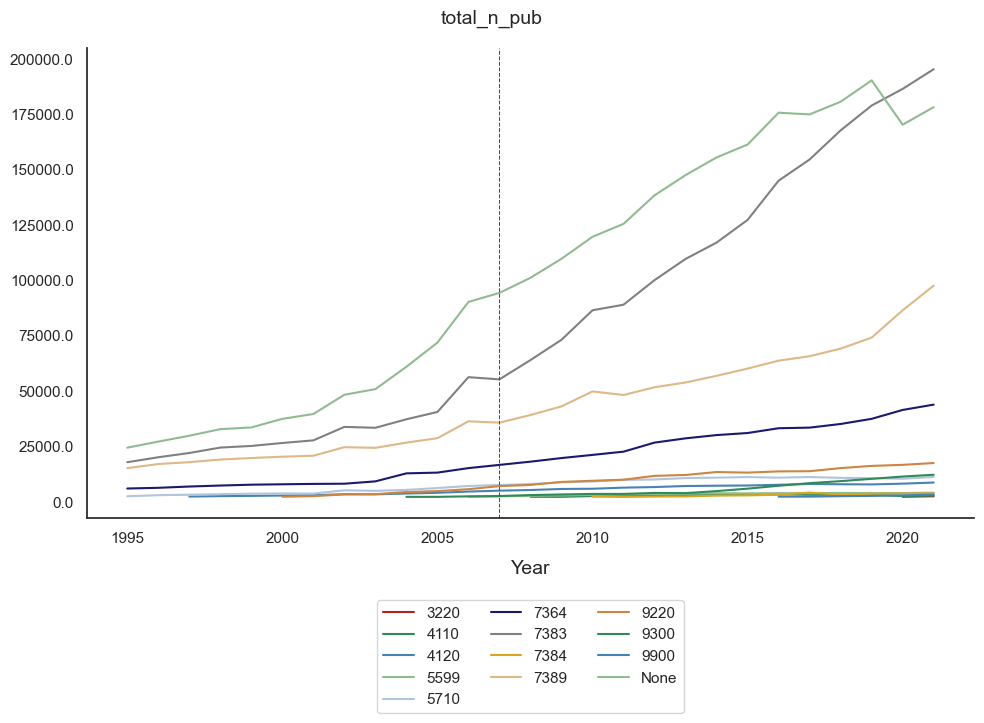

In [53]:
to_plot = agg_by_catjur[agg_by_catjur['total_n_pub']>2000]
year_of_change = [2007]
to_plot['catjur'] = to_plot['catjur'].fillna('None')
list_catjur = sorted(list(set(to_plot['catjur'])))
to_plot['catjur'] = pd.Categorical(to_plot['catjur'], list_catjur)

graph_3(to_plot, 'year', 'total_n_pub', 'catjur', list_catjur)

C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_29712\2388860756.py:63: UserWarning: set_ticklabels() should only be used with a fixed n

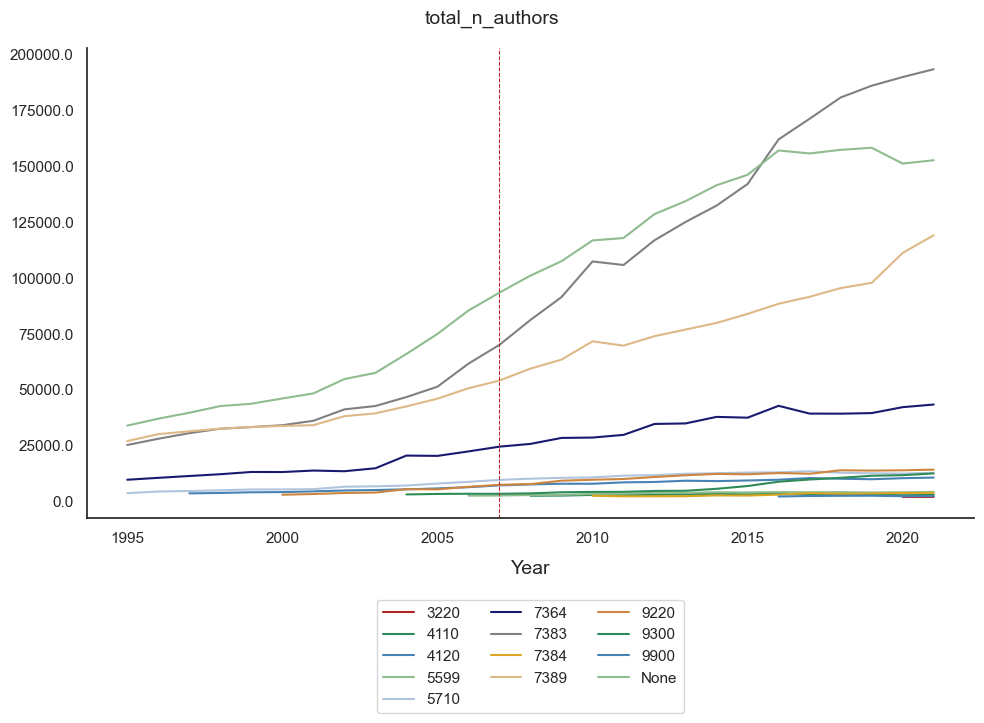

In [54]:
graph_3(to_plot, 'year', 'total_n_authors', 'catjur', list_catjur)

C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_10364\1568416090.py:65: UserWarning: set_ticklabels() should only be used with a fixed n

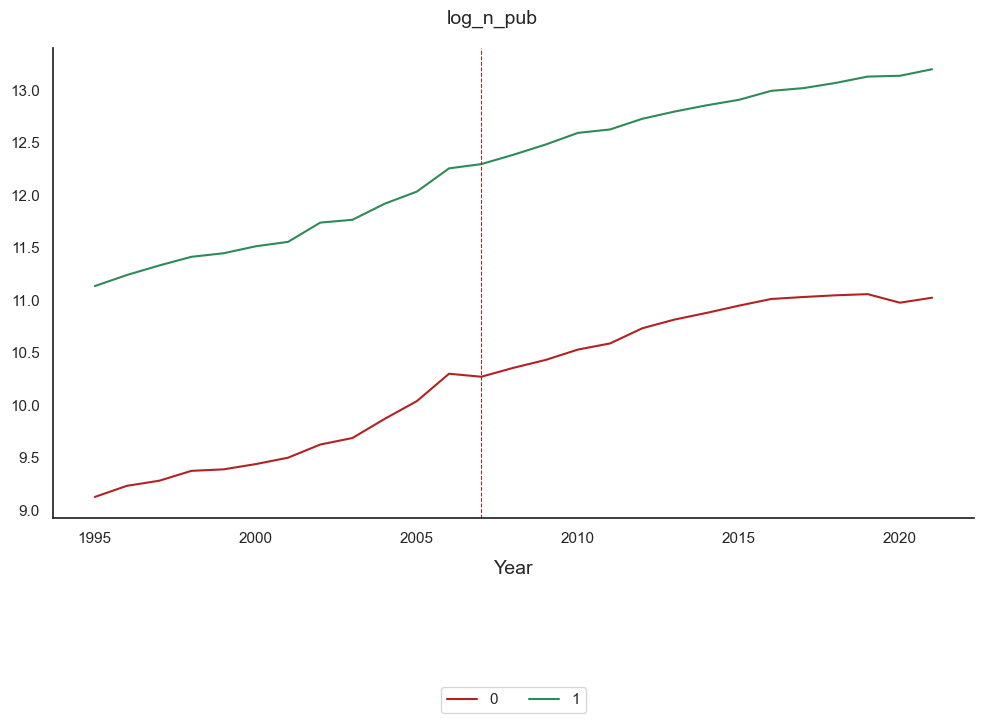

In [22]:
import numpy as np
to_plot = agg_by_linked[agg_by_linked['total_n_pub']>2000]
year_of_change = [2007]
to_plot['linked'] = pd.Categorical(to_plot['linked'], [0,1])
to_plot['log_n_pub'] = np.log(to_plot['total_n_pub'])
graph_3(to_plot, 'year', 'log_n_pub', 'linked', [0,1])

C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_10364\1568416090.py:65: UserWarning: set_ticklabels() should only be used with a fixed n

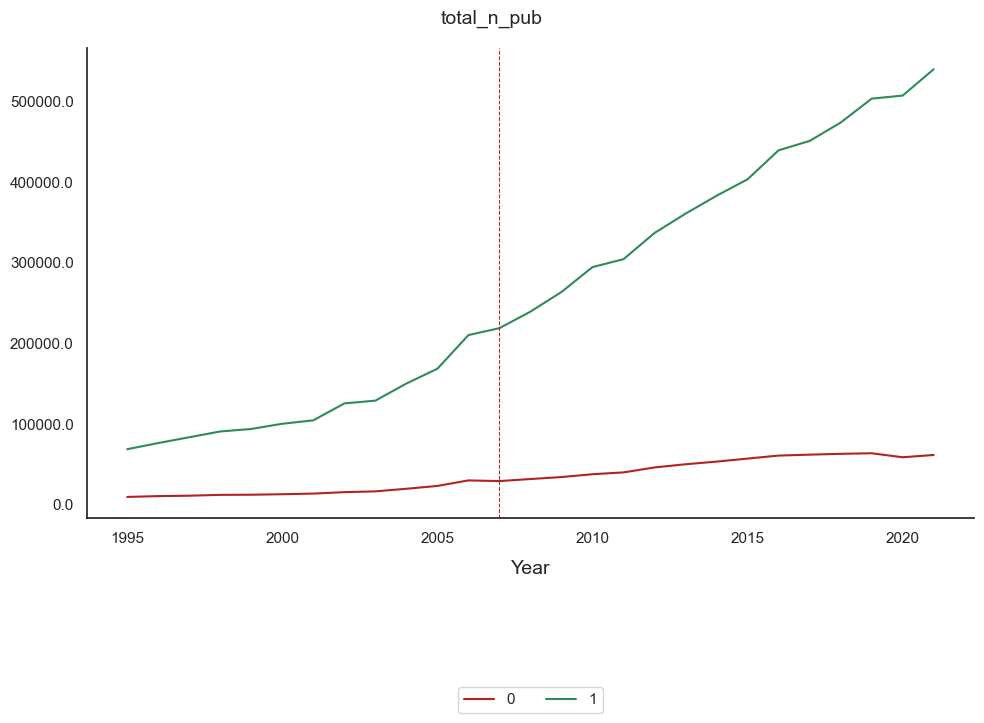

In [23]:
graph_3(to_plot, 'year', 'total_n_pub', 'linked', [0,1])

C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_31996\2388860756.py:63: UserWarning: set_ticklabels() should only be used with a fixed n

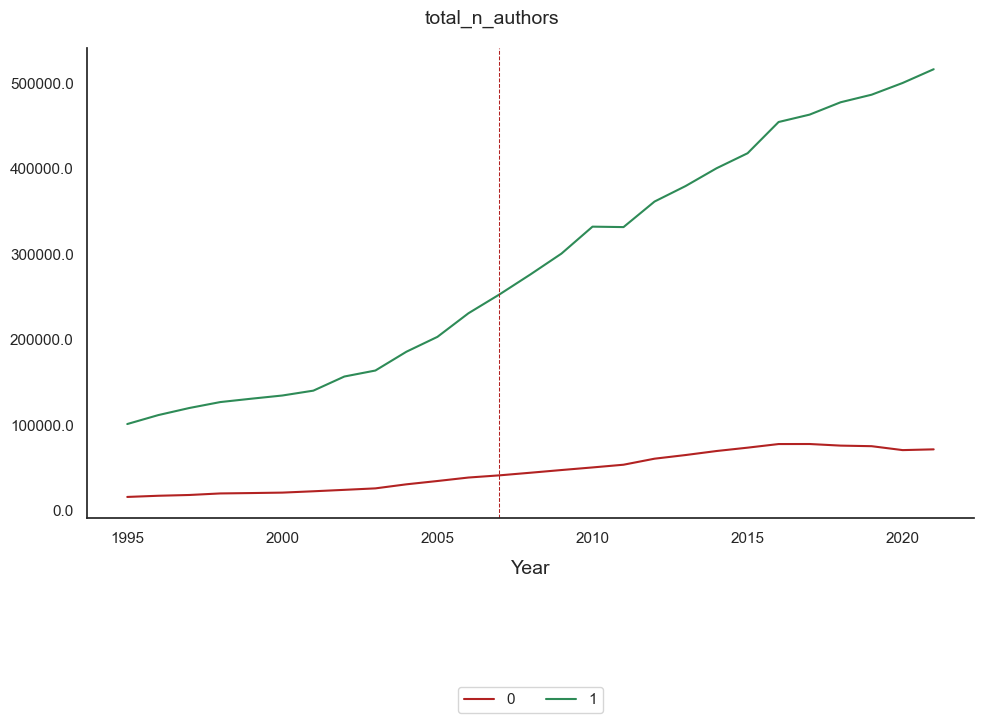

In [38]:
graph_3(to_plot, 'year', 'total_n_authors', 'linked', [0,1])

C:\Users\rapha\AppData\Local\Temp\ipykernel_10364\2955117348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['kind'] = pd.Categorical(to_plot['kind'], kinds)
C:\Users\rapha\AppData\Local\Temp\ipykernel_10364\2955117348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['log_n_pub'] = np.log(to_plot['total_n_pub'])
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf val

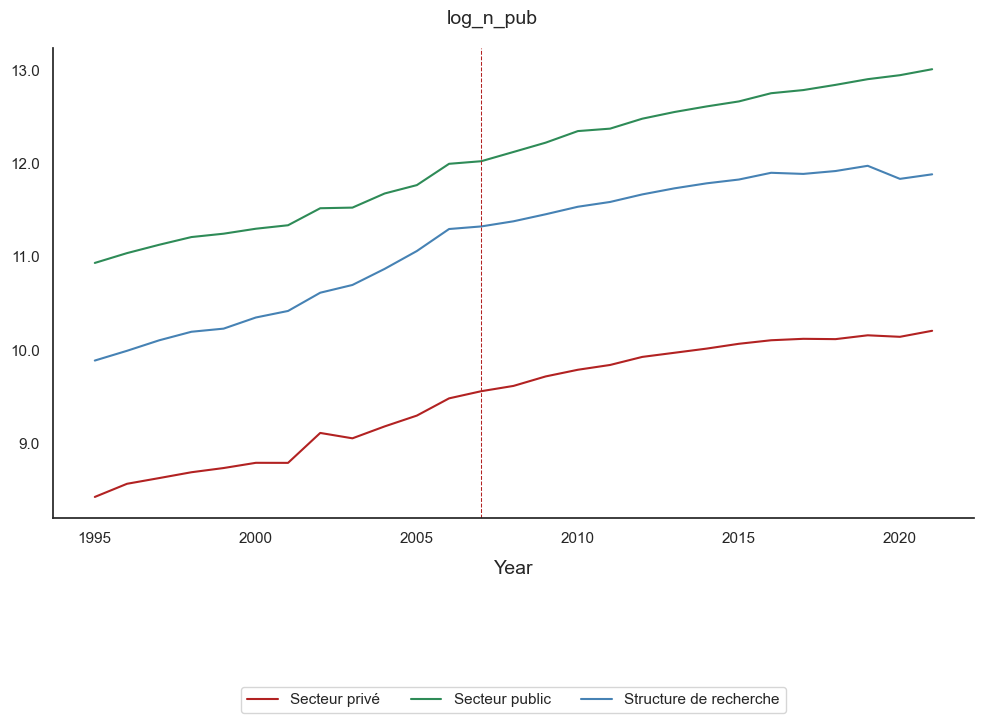

In [26]:
import numpy as np
to_plot = agg_by_kind[agg_by_kind['total_n_pub']>2000]
year_of_change = [2007]
kinds= sorted(list(set(to_plot['kind'])))
to_plot['kind'] = pd.Categorical(to_plot['kind'], kinds)
to_plot['log_n_pub'] = np.log(to_plot['total_n_pub'])
graph_3(to_plot, 'year', 'log_n_pub', 'kind', kinds)

C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_10364\1568416090.py:65: UserWarning: set_ticklabels() should only be used with a fixed n

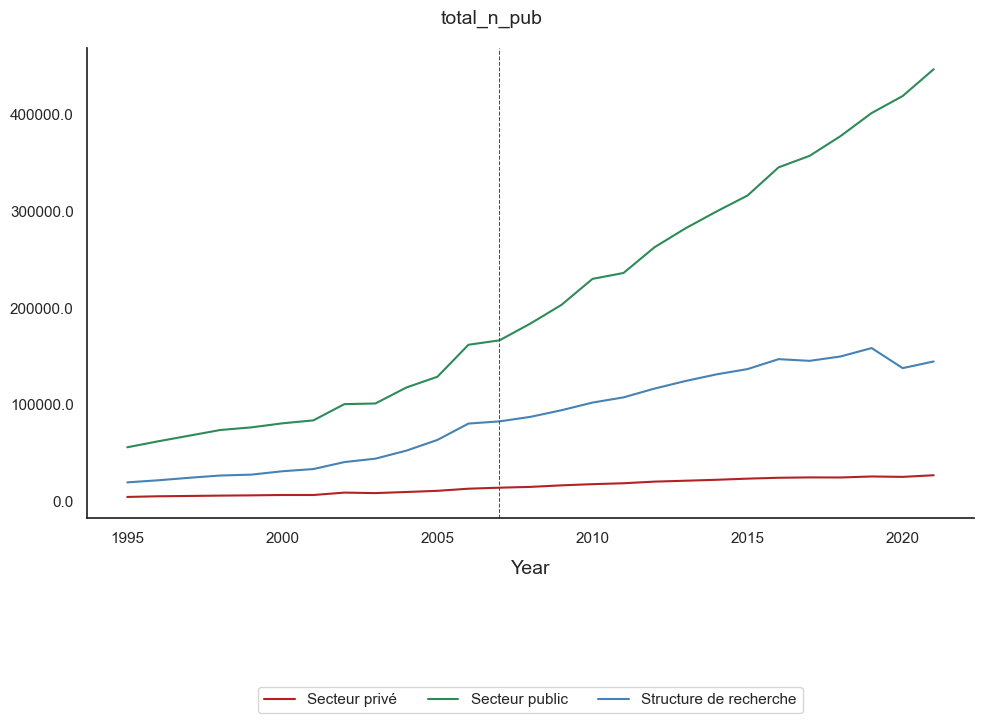

In [27]:
graph_3(to_plot, 'year', 'total_n_pub', 'kind', kinds)